# 1. Introduction

<b> Khách hàng rời đi (Customer churn) là gì? Tại sao điều này lại quan trọng? </b>

Đối với các công ty viễn thông, khách hàng là những người dùng đã và đang đăng kí dịch vụ của họ. Và đương nhiên họ có khả năng ngừng đăng kí dịch vụ, khi đó công ty nhận định rằng họ đã rời đi.<br><br>

Khách hàng đăng kí dịch vụ đồng nghĩa họ mang lại lợi nhuận cho công ty cung cấp dịch vụ. Vì vậy, khách hàng đăng kí càng nhiều dịch vụ và ở lại càng lâu đồng nghĩa với việc lợi nhuận thu được của công ty càng lớn. Khi đó, bài toán được sinh ra dành cho công ty là làm sao để có thể làm hài lòng khách hàng của họ nhiều nhất có thể (nhưng vẫn có lợi nhuận), để khách hàng có thể ở lại công ty càng lâu càng tốt.<br><br>

Đối với một công ty cung cấp dịch vụ hàng đầu (chẳng hạn như Viettel), lượng người dùng/khách hàng đăng kí là rất lớn. Vì vậy, việc để ý và làm hài lòng toàn bộ khách hàng của họ là điều rất khó. Thay vào đó, các công ty có xu hướng dự đoán nhóm khách hàng nào của họ có tỉ lệ rời đi cao và tập trung làm mọi cách để có thể giữ nhóm khách hàng này lại. <br><br>

Và kết quả là với việc giữ chân nhóm người dùng cũ cộng với thêm sự gia nhập của nhóm khách hàng mới, lợi nhuận mà công ty đó thu được càng cao, kéo theo những lợi ích to lớn sau này. <br><br>

<b>Mục tiêu:</b><br><br>
Chúng ta sẽ tìm hiểu về dataset của một công ty cung cấp dịch vụ viễn thông và cố gắng hiểu những vấn đề được đặt ra như:
- Tỉ lệ rời đi của người dùng vào tháng sau là bao nhiêu? Điều đó ảnh hưởng đến doanh thu của công ty như thế nào?
- Mối tương quan giữa nhóm người dùng rời đi và nhóm người dùng ở lại?
- Những dịch vụ được công ty cung cấp ảnh hưởng như thế nào đến việc người dùng của họ rời đi vào tháng sau?
- Có thể cải thiện những dịch vụ nào để có thể giữ chân khách hàng?

# 2. Tải lên thư viện và dữ liệu

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, precision_recall_curve, auc

from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from PIL import Image
from IPython.display import clear_output

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

In [4]:
raw_data = pd.read_csv('Dataset/VDT2022_Telco_Customer_Churn_Dataset.csv')

# 3. Tìm hiểu về dữ liệu

- Mỗi hàng là thông tin tổng hợp của mỗi người dùng
- Mỗi cột chứa thuộc tính của người dùng

In [5]:
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


Những thuộc tính bao gồm: <br>
- `Churn`: Khách hàng có rời dịch vụ vào tháng sau hay không (mục tiêu)
- `customerID`: ID đăng kí của mỗi khách hàng khi đăng kí dịch vụ
- `gender`, `SeniorCitizen`, `Partner`, `Dependents`: Thông tin nhân khẩu học của khách hàng bao gồm: giới tính, nhóm tuổi tác (lớn hơn 62 tuổi hay không), có vợ/chồng hay người phụ thuộc hay không
- `tenure`: Số tháng đăng kí dịch vụ của người dùng
- `MonthlyCharges`: Số tiền mà người dùng đã chi cho dịch vụ vào tháng này
- `TotalCharges`: Tổng số tiền mà người dùng đã chi cho dịch vụ của công ty
- `PhoneService`, `MultipleLines`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `Contract`, `PaperlessBilling`, `PaymentMethod`: những dịch vụ mà công ty cung cấp để người dùng đăng kí

In [6]:
raw_data.shape

(7043, 21)

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# 4. Thao tác với dữ liệu

Hãy làm sạch dữ liệu 1 chút
- `SeniorCitizen` sẽ là object vì feature này cho biết khách hàng thuộc 2 nhóm đối tượng: lớn tuổi (>= 62t) và không
- `TotalCharges` sẽ là float64 vì feature này cho biết tổng doanh thu do 1 khách hàng tạo ra từ trước đến giờ

In [8]:
raw_data['SeniorCitizen'] = raw_data['SeniorCitizen'].astype('object')
raw_data['TotalCharges'] = pd.to_numeric(raw_data['TotalCharges'], errors='coerce')

In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Có vẻ có 1 số dữ liệu lộn xộn (messy data) ở feature `TotalCharges`

Có 1 số ít dữ liệu bị thiếu ở feature `TotalCharges` sau khi đã được chỉnh sửa<br> Hãy tìm hiểu 1 chút:

In [10]:
raw_data['TotalCharges'].isna().sum()

11

In [11]:
raw_data[np.isnan(raw_data['TotalCharges'])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,NaN,No


- Có thể thấy mặc dù thông tin của khách hàng đều có đầy đủ giá trị ở `tenure` và `MonthlyCharges` nhưng lại thiếu đi giá trị ở `TotalCharges`. <br>
- Điều đặc biệt là giá trị ở `tenure` của 11 khách hàng này đều là 0. Vì vậy, chúng ta có thể đưa ra kết luận rằng đây là những khách hàng mới đăng kí vào dịch vụ của công ty vào tháng này. Do đó họ sẽ chưa có giá trị `TotalCharges` để công ty ghi nhận. 
- Vì là nhóm khách hàng mới, chúng ta sẽ điền giá trị vào `TotalCharges` là 0

In [12]:
raw_data['TotalCharges'].fillna(0, inplace=True)

In [13]:
raw_data.info()
raw_data.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

# 5. Trực quan hóa dữ liệu

In [14]:
raw_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,"7,043.000","7,043.000","7,043.000"
mean,32.371,64.762,"2,279.734"
std,24.559,30.090,"2,266.794"
min,0.000,18.250,0.000
25%,9.000,35.500,398.550
50%,29.000,70.350,"1,394.550"
75%,55.000,89.850,"3,786.600"
max,72.000,118.750,"8,684.800"


- Một nửa người dùng dịch vụ đăng kí hơn 29 tháng - hơn 2 năm
- Doanh thu trung bình theo tháng của công ty khoảng `$65`/khách hàng
- Tổng doanh thu của công ty khoảng `$2280`/khách hàng

In [15]:
raw_data.groupby('Churn').describe().T

Churn                       No       Yes
tenure         count 5,174.000 1,869.000
               mean     37.570    17.979
               std      24.114    19.531
               min       0.000     1.000
               25%      15.000     2.000
               50%      38.000    10.000
               75%      61.000    29.000
               max      72.000    72.000
MonthlyCharges count 5,174.000 1,869.000
               mean     61.265    74.441
               std      31.093    24.666
               min      18.250    18.850
               25%      25.100    56.150
               50%      64.425    79.650
               75%      88.400    94.200
               max     118.750   118.350
TotalCharges   count 5,174.000 1,869.000
               mean  2,549.911 1,531.796
               std   2,329.954 1,890.823
               min       0.000    18.850
               25%     572.900   134.500
               50%   1,679.525   703.550
               75%   4,262.850 2,331.300
               max   8,672.450 8,684.800

- Dễ dàng thấy được trung bình số tháng đăng kí của những người ở lại cao hơn những người rời đi
- Trung bình `MonthlyCharges` của những người rời đi lại cao hơn những người ở lại, điều này cần tìm hiểu kĩ để có thể đưa ra kết luận

In [16]:
raw_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [17]:
raw_data.to_csv('Dataset/Export for Tableau/VDT2022_Telco_Customer_Churn_Dataset_Tableau.csv')

In [18]:
raw_data['Churn'] = raw_data['Churn'].replace({'No':0, 'Yes':1})

In [19]:
def cat_predictor_plot(df, feature, target_label):
    
    """Function returning an univariate predictor plot where the underlying feature is categorical"""
        
    #If the feature is categorical 
    if df[feature].dtypes=="O":
        
        #Statistics
        stats=df.groupby(feature)[target_label].agg(["count", "sum", "mean"]).reset_index()
        stats["no_other"]=stats["count"]-stats["sum"]
        stats.columns=[feature, "no_records", "no_target", "prop_target", "no_other"]
        stats[["prop_target"]]=stats[["prop_target"]].round(2)
        stats[["no_records","no_target","no_other"]]=stats[["no_records","no_target","no_other"]].astype(int)
        prior_target=df[target_label].agg("mean")

        #Plot
        plt.figure()
        stats["no_target"].plot(kind="bar", width=0.5, color="thistle")
        stats["no_other"].plot(kind="bar", bottom=stats["no_target"], width=0.5, color="rebeccapurple")
        plt.ylabel("Total", rotation=90, labelpad=10, fontsize=12)
        stats["prop_target"].plot(secondary_y=True, color="red")
        plt.ylabel("Proportion", rotation=90, labelpad=20, fontsize=12)
        plt.axhline(y=prior_target, linewidth=1, color='black')
        plt.xticks(np.arange(len(stats)), stats.index)
        plt.xlim([-0.5, len(stats)-0.5])
        plt.ylim([0, np.max(stats["prop_target"])+0.01])
        plt.title(label="Predictor plot - "+feature, fontsize=20)
        plt.show()

    else:
        raise ValueError("Provide a categorical feature part of the dataset.")
        
    return stats.drop("no_other", axis=1)

0   0.735
1   0.265
Name: Churn, dtype: float64

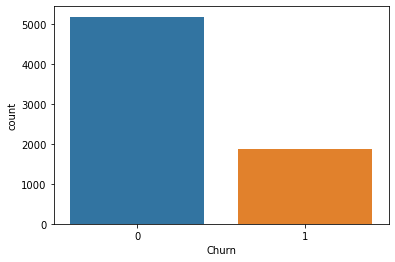

In [20]:
sns.countplot(x='Churn', data=raw_data)

raw_data['Churn'].value_counts(normalize=True)

In [21]:
print('Tổng doanh thu bị mất tháng này dựa trên lượng khách hàng rời đi: $' + str(raw_data[raw_data['Churn'] == 'Yes']['MonthlyCharges'].sum()))

Tổng doanh thu bị mất tháng này dựa trên lượng khách hàng rời đi: $0.0


- Công ty bị sụt giảm `$140k` doanh thu tháng này vì nhóm khách hàng rời bỏ dịch vụ
- `26.54%` người dùng rời dịch vụ chiếm `30.5%` doanh thu

#### Hãy tìm hiểu các feature của dữ liệu

## `gender`

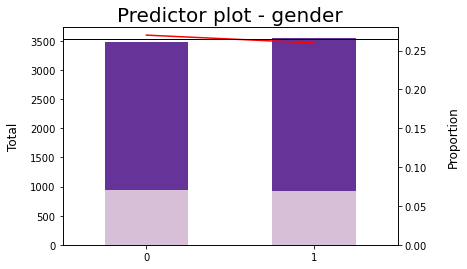

,gender,no_records,no_target,prop_target
0,Female,3488,939,0.270
1,Male,3555,930,0.260


In [22]:
cat_predictor_plot(raw_data, 'gender', 'Churn')

In [23]:
raw_data.groupby('gender')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
gender,,,
Female,32.245,65.204,"2,279.918"
Male,32.495,64.327,"2,279.554"


- Giới tính của người đăng kí không làm ảnh hưởng đến việc họ rời dịch vụ hay không 
- Giới tính của người đăng kí không gây ảnh hưởng đến doanh thu của công ty

## `SeniorCitizen`

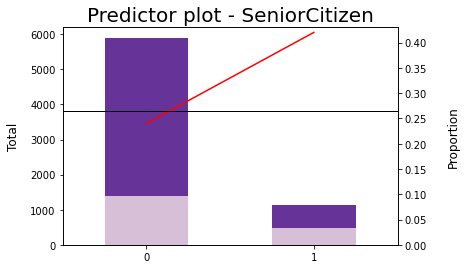

,SeniorCitizen,no_records,no_target,prop_target
0,0,5901,1393,0.240
1,1,1142,476,0.420


In [24]:
cat_predictor_plot(raw_data, 'SeniorCitizen', 'Churn')

Text(0.5, 1.0, 'SeniorCitizen vs TotalCharges')

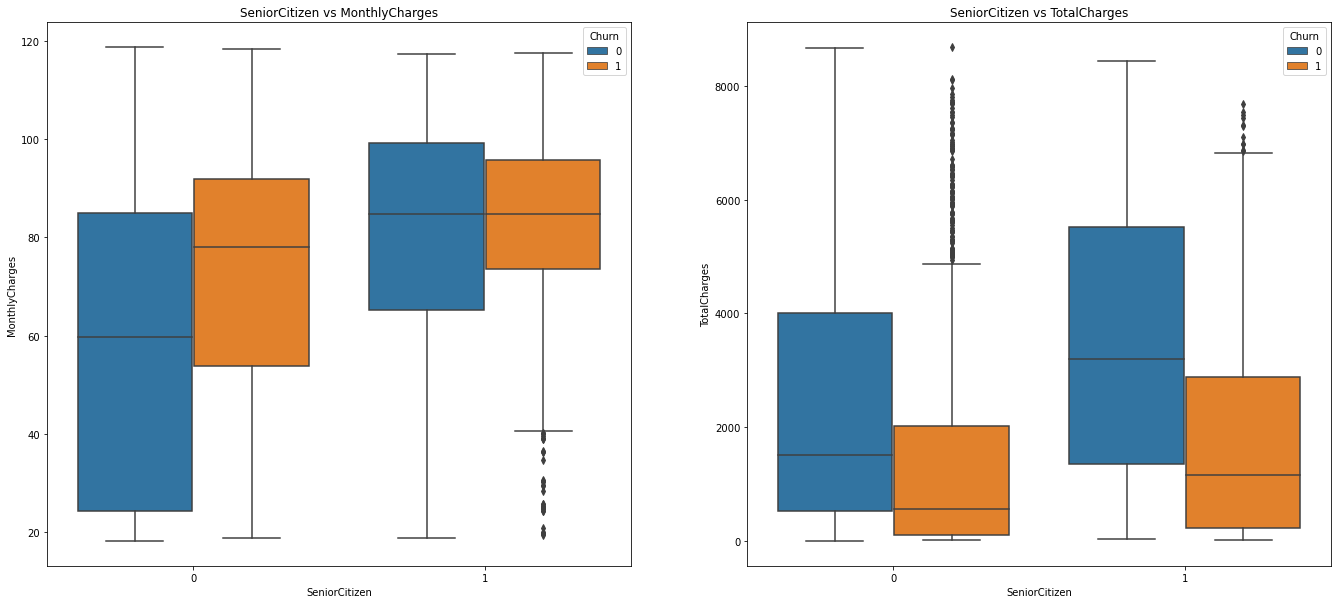

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(23,10))

sns.boxplot(x='SeniorCitizen', y='MonthlyCharges', hue='Churn', data=raw_data, ax=ax[0])
sns.boxplot(x='SeniorCitizen', y='TotalCharges', hue='Churn', data=raw_data, ax=ax[1])

ax[0].set_title('SeniorCitizen vs MonthlyCharges')
ax[1].set_title('SeniorCitizen vs TotalCharges')

Phần lớn những người dùng dịch vụ tháng này đều là Non-Senior Citizen, chiếm `83.79%`

- Chúng ta có thể thấy những `SeniorCitizen` chi nhiều tiền hơn cho dịch vụ của công ty. Họ có trung bình `MonthlyCharges` và `TotalCharges` cao hơn. Nhưng họ chỉ chiếm `16.21%` lượng người đăng kí và có tỉ lệ bỏ dịch vụ rất cao lên tới `41.68%`
- Tổng doanh thu của công ty vẫn đến chủ yếu từ những Non-Senior Citizen vì họ chiếm `83.79%` lượng người đăng kí và có tỉ lệ bỏ dịch vụ vào tháng sau ít hơn với `23.61%` <br>
<b>Tỉ lệ bỏ dịch vụ của Senior Citizen là rất đáng chú ý</b>

## `Partner`

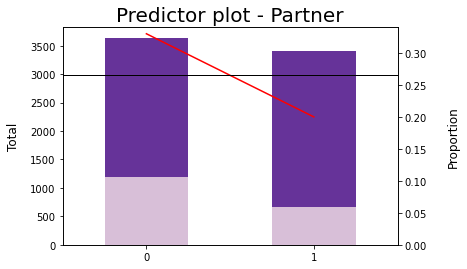

,Partner,no_records,no_target,prop_target
0,No,3641,1200,0.330
1,Yes,3402,669,0.200


In [26]:
cat_predictor_plot(raw_data, 'Partner', 'Churn')

,tenure,MonthlyCharges,TotalCharges
Partner,,,
No,23.358,61.945,"1,584.090"
Yes,42.018,67.776,"3,024.250"


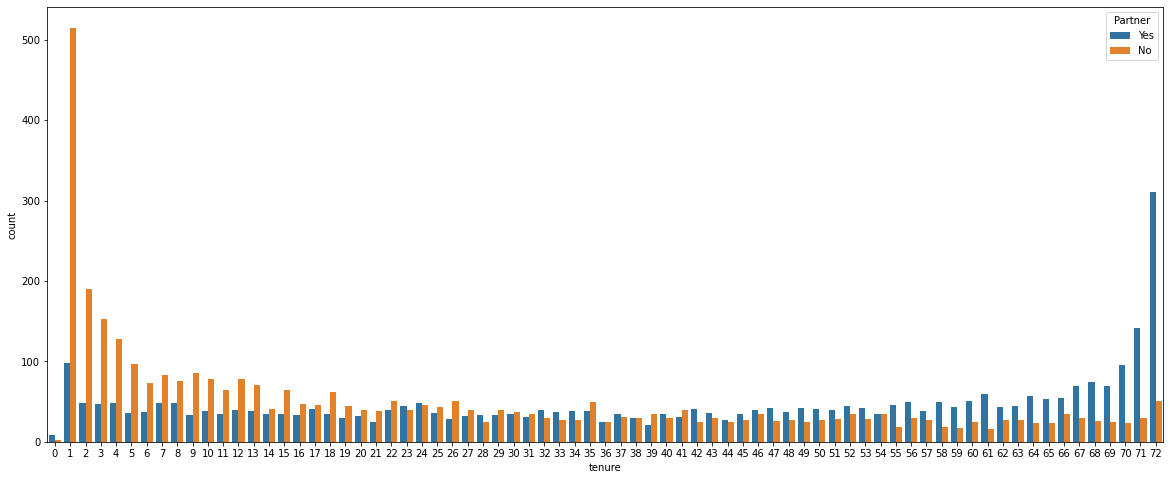

In [27]:
plt.figure(figsize=(20,8))
sns.countplot(x='tenure', hue='Partner', data=raw_data)

raw_data.groupby('Partner')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

- Có thể thấy được nhóm người có `Partner` có xu hướng ở lại với công ty lâu hơn
- Tỉ lệ rời dịch vụ của những người không có `Partner` cao hơn những người có `Partner`
- Thời gian đăng kí càng lâu, tỉ lệ của nhóm người có `Partner` càng tăng
- Trung bình doanh thu theo tháng công ty thu được từ những người có `Partner` so với những người không có `Partner` là gần như nhau
- Nhưng điều đáng chú ý là những người có `Partner` gắn bó với dịch vụ lâu hơn rất nhiều. Vì vậy tổng doanh thu thu được từ những người có `Partner` sẽ cao hơn

## `Dependents`

<AxesSubplot:xlabel='Partner', ylabel='count'>

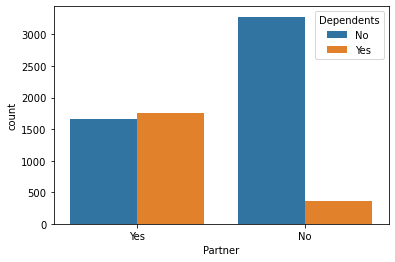

In [28]:
sns.countplot(x='Partner', hue='Dependents', data=raw_data)

Dễ dàng thấy được những người có `Partner` sẽ có nhiều người phụ thuộc (con cái) hơn những người độc thân

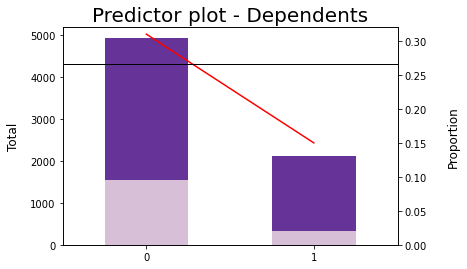

,Dependents,no_records,no_target,prop_target
0,No,4933,1543,0.310
1,Yes,2110,326,0.150


In [29]:
cat_predictor_plot(raw_data, 'Dependents', 'Churn')

`70.04%` những người đăng kí không có người phụ thuộc

Có thể thấy được tỉ lệ rời dịch vụ của những người có người phụ thuộc thấp hơn nhiều so với những người không có người phụ thuộc (`15.45%` vs `31.28%`)

,tenure,MonthlyCharges,TotalCharges
Dependents,,,
No,29.806,67.003,"2,187.709"
Yes,38.368,59.522,"2,494.881"


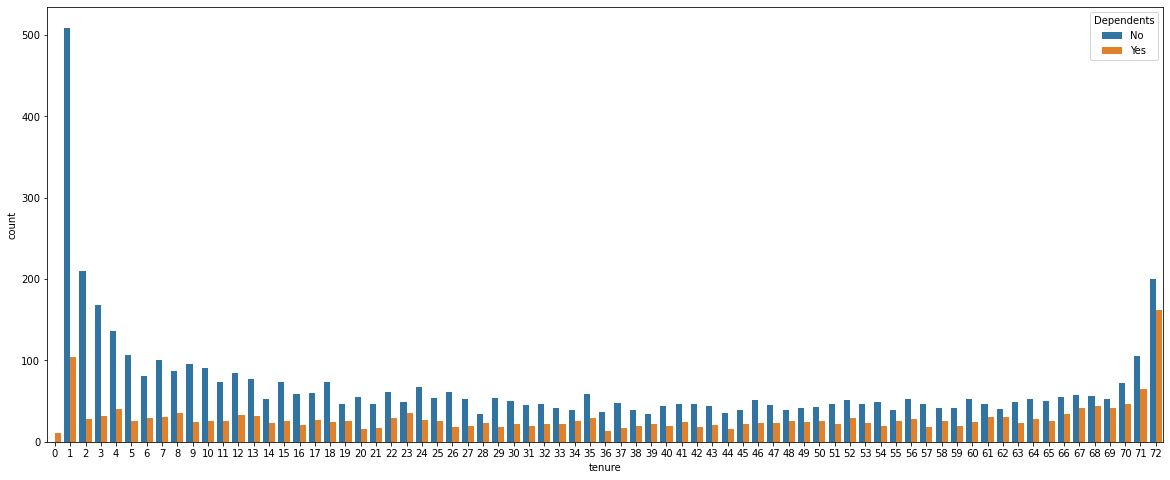

In [30]:
plt.figure(figsize=(20,8))
sns.countplot(x='tenure', hue='Dependents', data=raw_data)

raw_data.groupby('Dependents')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

- Có thể thấy được thời gian đăng kí càng lâu, tỉ lệ của nhóm người `Dependents` càng tăng
- Mặc dù chỉ chiếm khoảng `30%` lượng người đăng kí, nhưng nhóm người có `Dependents` trung bình chi nhiều tiền hơn cho dịch vụ và cung cấp doanh thu nhiều hơn cho công ty

## `tenure`

In [31]:
raw_data.describe()['tenure']

count   7,043.000
mean       32.371
std        24.559
min         0.000
25%         9.000
50%        29.000
75%        55.000
max        72.000
Name: tenure, dtype: float64

###### Sử dụng Tableau để có cái nhìn trực quan hơn

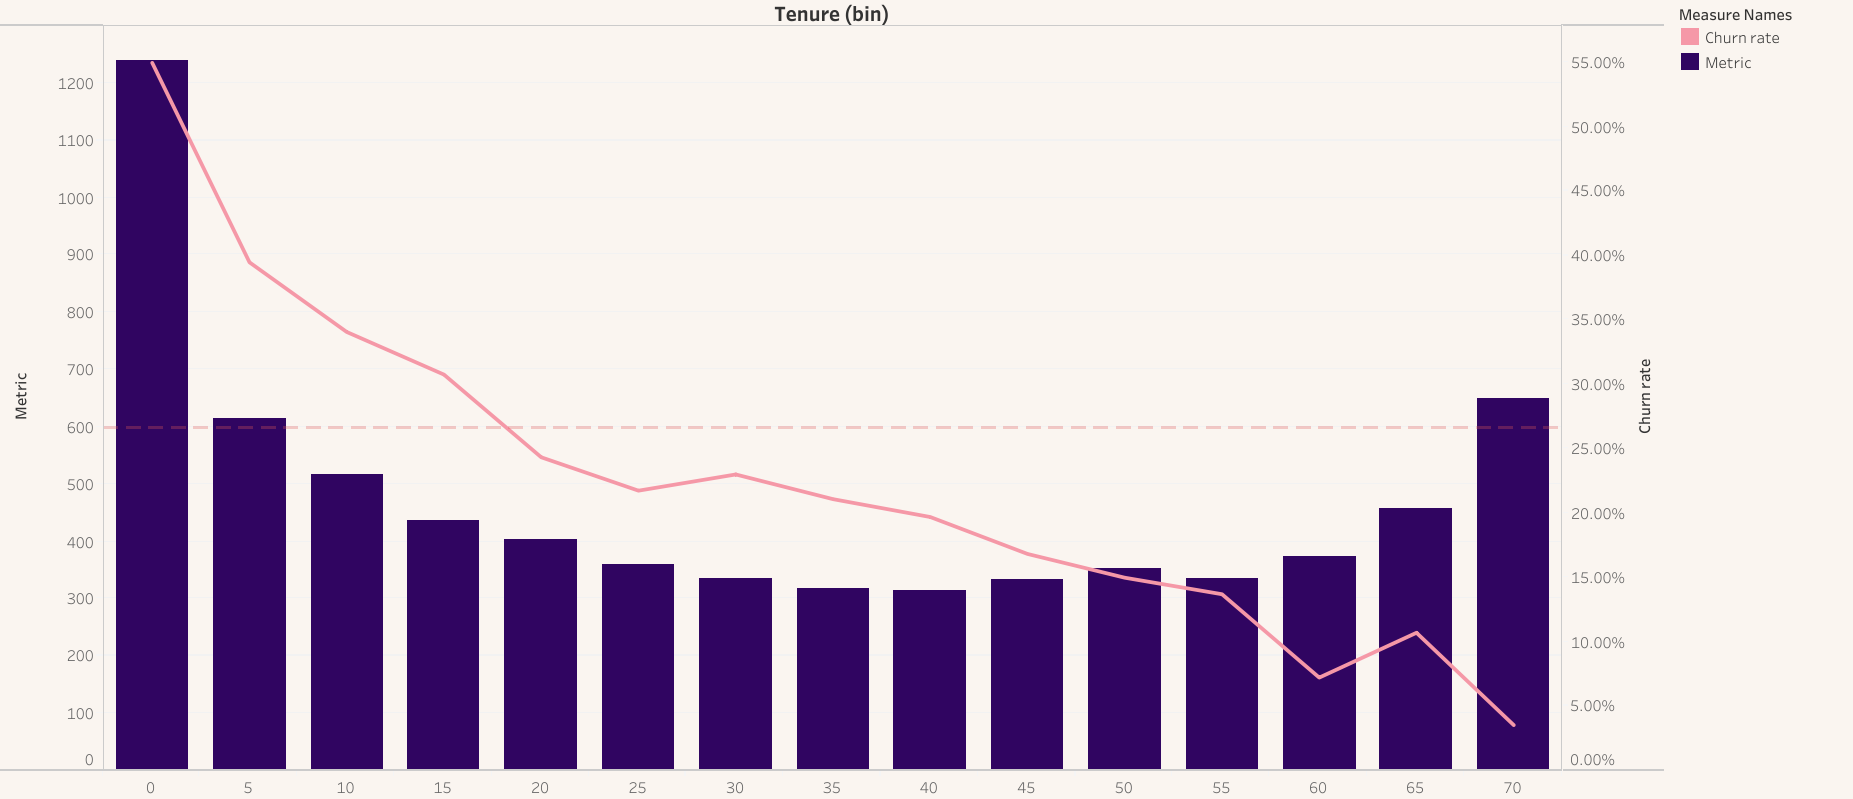

In [8]:
tenure_img = Image.open('Images from Tableau/Tenure.png')
tenure_img

<AxesSubplot:xlabel='Churn', ylabel='tenure'>

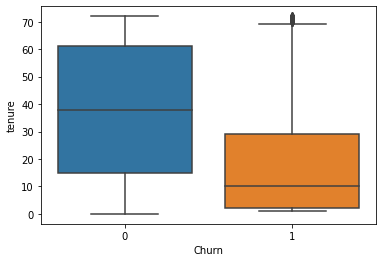

In [33]:
sns.boxplot(x='Churn', y='tenure', data=raw_data)

- Người dùng mới có xu hướng bỏ dịch vụ cao hơn so với người dùng lâu năm
- Tỉ lệ bỏ dịch vụ của những người đăng kí dưới 1 năm là rất cao (gần `50%`)
- Thời gian đăng kí càng lâu thì tỉ lệ người dùng rời đi vào tháng sau càng giảm mạnh

## `PhoneService`

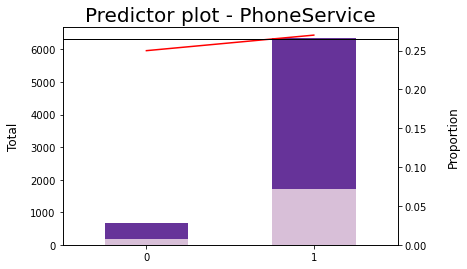

,PhoneService,no_records,no_target,prop_target
0,No,682,170,0.250
1,Yes,6361,1699,0.270


In [34]:
cat_predictor_plot(raw_data, 'PhoneService', 'Churn')

In [35]:
raw_data.groupby('PhoneService')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
PhoneService,,,
No,31.738,42.029,"1,496.034"
Yes,32.439,67.199,"2,363.759"


- `90.32%` người dùng dịch vụ cũng đăng kí `PhoneService`
- `PhoneService` không ảnh hưởng để việc người dùng có ở lại với công ty lâu hơn hay không
- Tỉ lệ rời đi của người dùng đăng kí `PhoneService` là `26.71%`, không đăng kí `PhoneService` là `24.93%`

## `MultipleLines`

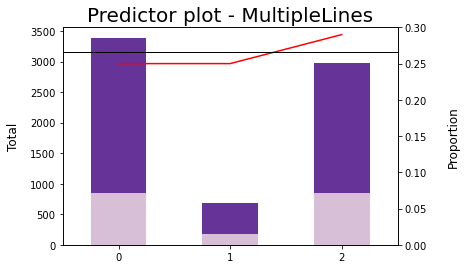

,MultipleLines,no_records,no_target,prop_target
0,No,3390,849,0.250
1,No phone service,682,170,0.250
2,Yes,2971,850,0.290


In [36]:
cat_predictor_plot(raw_data, 'MultipleLines', 'Churn')

In [37]:
raw_data.groupby('MultipleLines')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
MultipleLines,,,
No,24.135,54.195,"1,347.842"
No phone service,31.738,42.029,"1,496.034"
Yes,41.915,82.037,"3,522.951"


- `42.18%` người dùng đăng kí `MultipleLines`, `48.13%` không đăng kí `MultipleLines`, `9.69%` còn lại không đăng kí `PhoneService`
- Tỉ lệ rời đi của nhóm người dùng đăng kí `MultipleLines` lại cao hơn nhưng không đáng kể với `28.61%`( so với `25.04%`(không đăng kí `MultipleLines`) và `24.93%`(không đăng kí `PhoneService`))
- Doanh thu kiếm được từ những người đăng kí `MultipleLines` cao hơn hẳn so với những người đăng kí 2 hình thức còn lại 
- Nhóm người đăng kí `MultipleLines` có xu hướng ở lại với công ty lâu hơn

## `InternetService`

In [38]:
pd.crosstab(raw_data['InternetService'], raw_data['PhoneService'])

PhoneService,No,Yes
InternetService,,
DSL,682,1739
Fiber optic,0,3096
No,0,1526


Khoảng `21.67%` người dùng dịch vụ không đăng kí `InternetService`

- Gói `Filber optic` chỉ dành cho những người đăng kí `PhoneService` nên có thể hiểu rằng đây là 1 gói cao cấp
- Gói `DSL` khả dụng cho cả 2 nhóm đăng kí `PhoneService` hoặc không

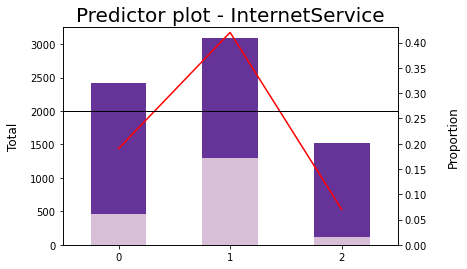

,InternetService,no_records,no_target,prop_target
0,DSL,2421,459,0.190
1,Fiber optic,3096,1297,0.420
2,No,1526,113,0.070


In [39]:
cat_predictor_plot(raw_data, 'InternetService', 'Churn')

In [40]:
print(raw_data.groupby('InternetService')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean())

                 tenure  MonthlyCharges  TotalCharges
InternetService                                      
DSL              32.822          58.102     2,115.411
Fiber optic      32.918          91.500     3,205.305
No               30.547          21.079       662.605


- Gói `Fiber optic` đem lại doanh thu cao nhất cho công ty vì có `43.96%` lượng người đăng kí và doanh thu thu được từ những người đăng kí gói này rất cao. Nhưng giá trị mà gói này mang lại cho người dùng chưa xứng đáng vì họ có tỉ lệ rời đi vào tháng sau rất lớn với `41.89%`
- Ngược lại, doanh thu thu được của công ty từ những người đăng kí gói `DSL` là thấp hơn nhiều nhưng những người dùng gói này khá hài lòng khi sử dụng gói vì tỉ lệ rời đi của họ thấp hơn rất nhiều với `18.96%`
- Khoảng `21.67%` người dùng không đăng kí `InternetService` và tỉ lệ rời đi vào tháng sau của họ cũng thấp nhất với `7.41%` nhưng doanh thu công ty thu được từ nhóm người này thấp hơn hẳn so với nhóm người đăng kí `InternetService`
- Các gói `InternetService` không ảnh hưởng đến việc người dùng ở lại với công ty lâu hơn hay không

## `OnlineSecurity`

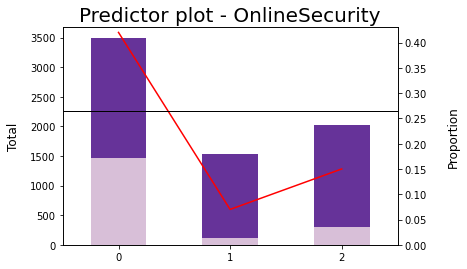

,OnlineSecurity,no_records,no_target,prop_target
0,No,3498,1461,0.420
1,No internet service,1526,113,0.070
2,Yes,2019,295,0.150


In [41]:
cat_predictor_plot(raw_data, 'OnlineSecurity', 'Churn')

- `49.67%` người dùng không đăng kí `OnlineSecurity` và nhóm người này có tỉ lệ rời đi rất cao
- Nhóm người đăng kí `OnlineSecurity` khá hài lòng với chất lượng dịch vụ vì họ có tỉ lệ rời đi thấp hơn rất nhiều

## `OnlineBackup`

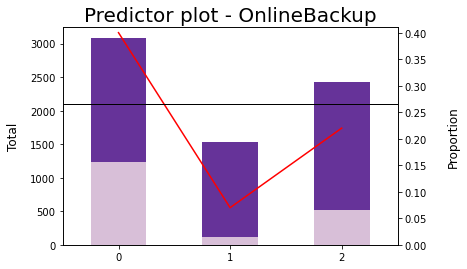

,OnlineBackup,no_records,no_target,prop_target
0,No,3088,1233,0.400
1,No internet service,1526,113,0.070
2,Yes,2429,523,0.220


In [42]:
cat_predictor_plot(raw_data, 'OnlineBackup', 'Churn')

Tương tự như nhóm người đăng kí `OnelineSecurity`, nhóm người không đăng kí `OnlineBackup` chiếm nhiều nhất với `43.85%` nhưng lại có tỉ lệ rời đi vào tháng sau cao hơn rất nhiều so với nhóm người có đăng kí `OnlineBackup`

## `DeviceProtection`

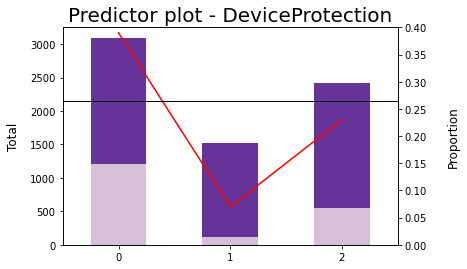

,DeviceProtection,no_records,no_target,prop_target
0,No,3095,1211,0.390
1,No internet service,1526,113,0.070
2,Yes,2422,545,0.230


In [43]:
cat_predictor_plot(raw_data, 'DeviceProtection', 'Churn')

Cũng tương tự như 2 dịch vụ trên, nhóm người không đăng kí `DeviceProtection` chiếm nhiều nhất với `43.94%` nhưng lại có tỉ lệ rời đi vào tháng sau cao hơn rất nhiều so với nhóm người có đăng kí `DeviceProtection`

## `TechSupport`

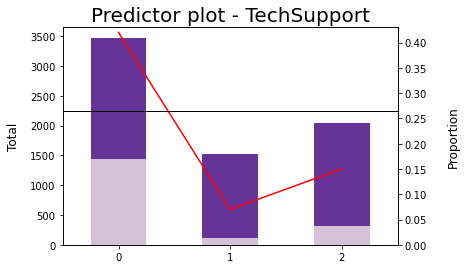

,TechSupport,no_records,no_target,prop_target
0,No,3473,1446,0.420
1,No internet service,1526,113,0.070
2,Yes,2044,310,0.150


In [44]:
cat_predictor_plot(raw_data, 'TechSupport', 'Churn')

Tương tự như 3 dịch vụ trên, nhóm người không đăng kí `TechSupport` chiếm nhiều nhất với `49.31%` nhưng lại có tỉ lệ rời đi vào tháng sau cao hơn rất nhiều so với nhóm người có đăng kí `TechSupport`

## `StreamingTV`

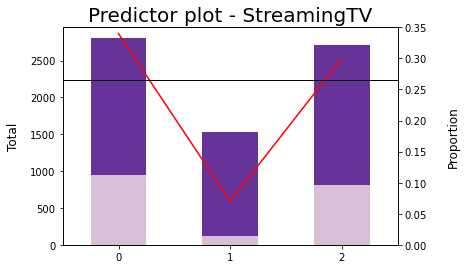

,StreamingTV,no_records,no_target,prop_target
0,No,2810,942,0.340
1,No internet service,1526,113,0.070
2,Yes,2707,814,0.300


In [45]:
cat_predictor_plot(raw_data, 'StreamingTV', 'Churn')

In [46]:
print(raw_data.groupby('StreamingTV')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean())

                     tenure  MonthlyCharges  TotalCharges
StreamingTV                                              
No                   24.985          65.388     1,734.790
No internet service  30.547          21.079       662.605
Yes                  41.066          88.737     3,757.027


- Khác với những nhóm dịch vụ trên, lượng người dùng đăng kí `StreamingTV` là khá cao với `38.43%` nhưng cũng có tỉ lệ rời đi vào tháng sau khá cao
- Những người đăng kí `StreamingTV` có xu hướng ở lại lâu hơn

## `StreamingMovies`

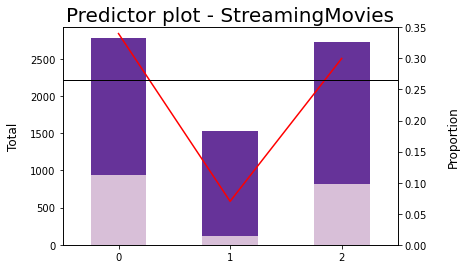

,StreamingMovies,no_records,no_target,prop_target
0,No,2785,938,0.340
1,No internet service,1526,113,0.070
2,Yes,2732,818,0.300


In [47]:
cat_predictor_plot(raw_data, 'StreamingMovies', 'Churn')

In [48]:
print(raw_data.groupby('StreamingMovies')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean())

                     tenure  MonthlyCharges  TotalCharges
StreamingMovies                                          
No                   24.712          65.434     1,713.068
No internet service  30.547          21.079       662.605
Yes                  41.197          88.476     3,760.666


<AxesSubplot:xlabel='StreamingTV,StreamingMovies'>

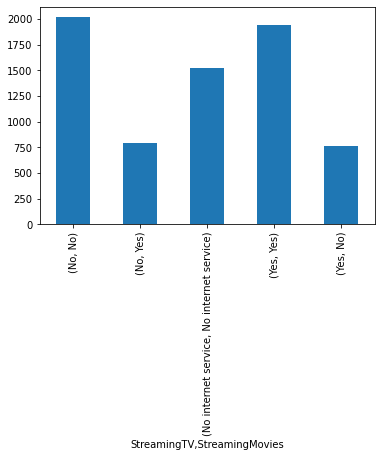

In [49]:
raw_data.groupby('StreamingTV')['StreamingMovies'].value_counts().plot(kind='bar')

- Tương tự với nhóm người dùng đăng kí `StreamingTV`, lượng người dùng đăng kí `StreamingMovies` là khá cao với `38.79%` nhưng cũng có tỉ lệ rời đi vào tháng sau khá cao
- Những người đăng kí `StreamingMovies` có xu hướng ở lại lâu hơn
- Người dùng có xu hướng đăng kí `StreamingTV` và `StreamingMovies` chung với nhau và ngược lại

## `Contract`

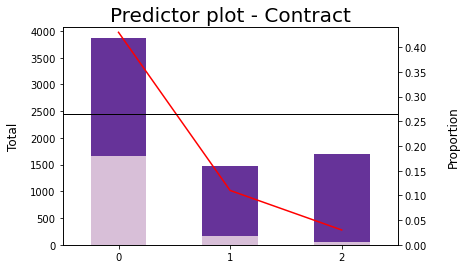

,Contract,no_records,no_target,prop_target
0,Month-to-month,3875,1655,0.430
1,One year,1473,166,0.110
2,Two year,1695,48,0.030


In [50]:
cat_predictor_plot(raw_data, 'Contract', 'Churn')

In [51]:
raw_data.groupby('Contract')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
Contract,,,
Month-to-month,18.037,66.398,"1,369.255"
One year,42.045,65.049,"3,032.623"
Two year,56.735,60.770,"3,706.934"


- Dễ dàng thấy được nhóm người đăng kí `Contract` theo tháng chiếm nhiều nhất nhưng cũng là nhóm người dễ rời đi nhất
- Nhóm người đăng kí `Contract` 1 năm và 2 năm có tỷ lệ rời đi rất thấp
- Nhóm người đăng kí `Contract` 2 năm có xu hướng ở lại với công ty lâu hơn
- Khá ngạc nhiên là tỷ lệ người dùng đăng kí gói `Contract` 2 năm lại nhiều hơn gói 1 năm (`24.1%` vs `20.91%`)

## `PaymentMethod`

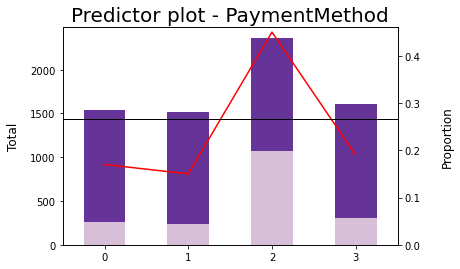

,PaymentMethod,no_records,no_target,prop_target
0,Bank transfer (automatic),1544,258,0.170
1,Credit card (automatic),1522,232,0.150
2,Electronic check,2365,1071,0.450
3,Mailed check,1612,308,0.190


In [52]:
cat_predictor_plot(raw_data, 'PaymentMethod', 'Churn')

In [53]:
print(raw_data.groupby('PaymentMethod')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean())

                           tenure  MonthlyCharges  TotalCharges
PaymentMethod                                                  
Bank transfer (automatic)  43.657          67.193     3,075.311
Credit card (automatic)    43.269          66.512     3,069.378
Electronic check           25.175          76.256     2,090.868
Mailed check               21.830          43.917     1,049.251


- `33.58%` người dùng đăng kí `Electronic check`, `22.89%` cho `Mailed check`, `21.92%` cho `Bank transfer` và `21.61%` cho `Credit card`
- Doanh thu từ gói `Electronic check` là cao nhất với lượng người dùng lớn
- Tỉ lệ rời đi của người dùng đăng kí gói `Electronic check` là cao nhất với `45.29%` (so với `16.71%` của `Bank transfer`, `15.24%` của `Credit card`, `19.11%` của `Mailed check`)
- 2 gói automatic là `Bank transfer` và `Credit card` có chất lượng dịch vụ tốt hơn vì có người dùng có xu hướng ở lại với công ty lâu hơn
- Gói `Mailed check` mang lại thu nhập thấp nhất cho công ty và người dùng gói này cũng có xu hướng rời công ty sớm hơn 

###### Mối quan hệ giữa `PaymentMethod` & `Contract`    

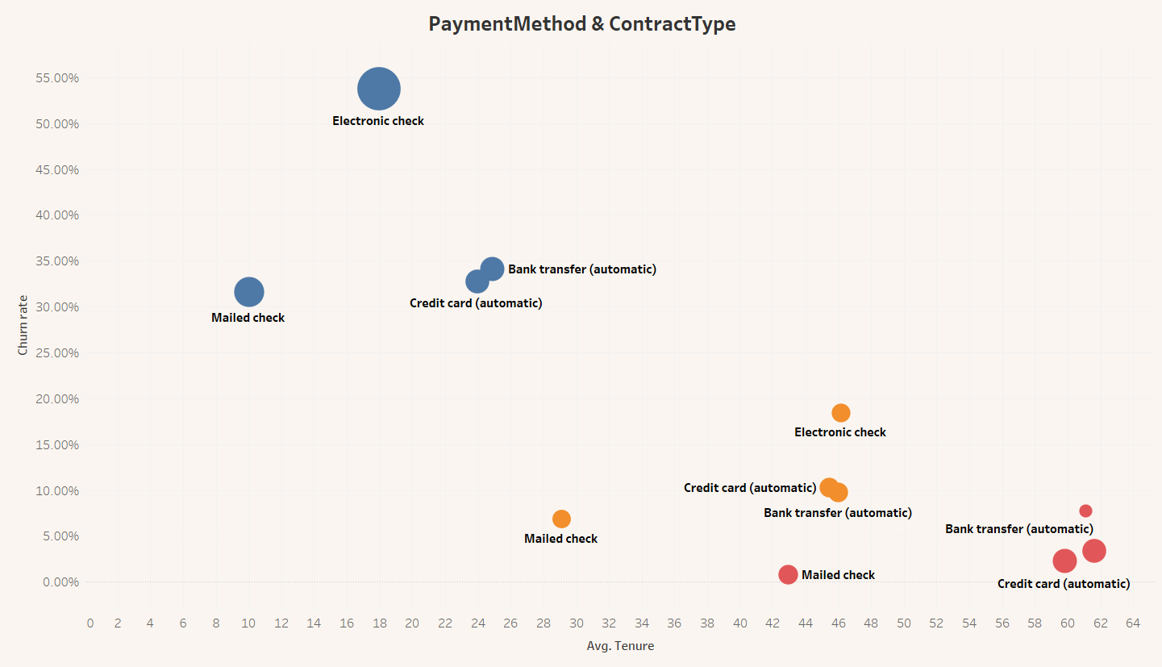

In [7]:
payment_and_contract = Image.open('Images from Tableau/PaymentMethod&ContractType.png')
payment_and_contract

## `PaperlessBilling`

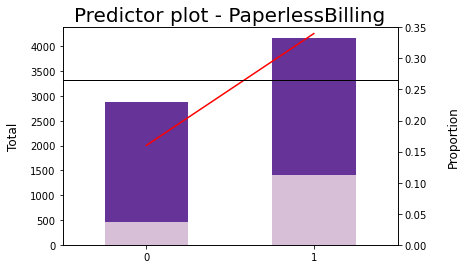

,PaperlessBilling,no_records,no_target,prop_target
0,No,2872,469,0.160
1,Yes,4171,1400,0.340


In [54]:
cat_predictor_plot(raw_data, 'PaperlessBilling', 'Churn')

In [55]:
raw_data.groupby('PaperlessBilling')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
PaperlessBilling,,,
No,32.189,51.993,"1,846.580"
Yes,32.497,73.554,"2,577.988"


- `59.22%` người dùng dịch vụ đăng kí `PaperlessBilling`
- Gói `PaperlessBilling` không mang lại nhiều giá trị cho người đăng kí vì họ có xu hướng rời đi vào tháng sau cao hơn với `33.57%` (so với `16.33%`)
- Nhóm người đăng kí `PaperlessBilling` cũng không có xu hướng ở lại với công ty lâu hơn

## `MonthlyCharges` & `TotalCharges`

<AxesSubplot:xlabel='tenure', ylabel='TotalCharges'>

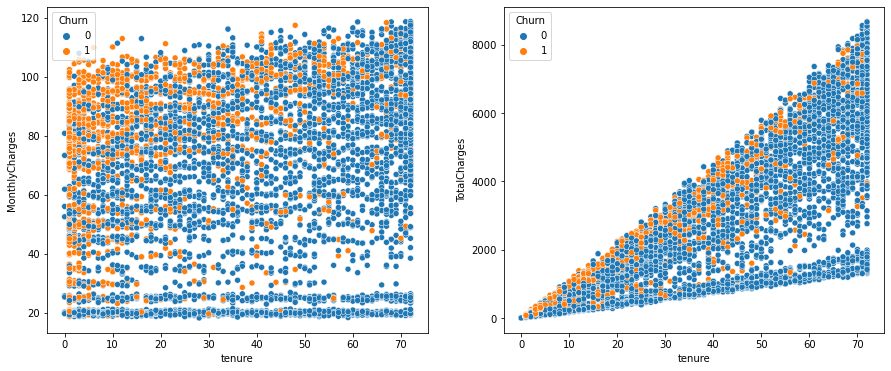

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=raw_data, ax=ax[0])
sns.scatterplot(x='tenure', y='TotalCharges', hue='Churn', data=raw_data, ax=ax[1])

<AxesSubplot:>

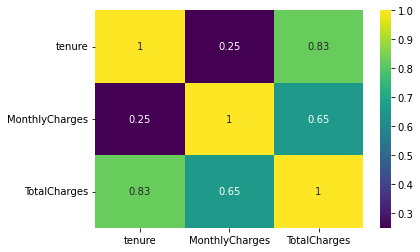

In [57]:
sns.heatmap(raw_data[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(), annot=True, cmap='viridis')

- Có thể thấy được mối quan hệ giữa `tenure`, `MonthlyCharges`, `TotalCharges` là linear và có mối tương quan dương
- Mối tương quan giữa `tenure` và `TotalCharges` mạnh hơn so với mối tương quan giữa `tenure` và `MonthlyCharges` rất nhiều

In [58]:
Q1 = raw_data[['MonthlyCharges', 'TotalCharges']].quantile(0.25)
Q2 = raw_data[['MonthlyCharges', 'TotalCharges']].quantile(0.5)
Q3 = raw_data[['MonthlyCharges', 'TotalCharges']].quantile(0.75)

<AxesSubplot:xlabel='Churn', ylabel='TotalCharges'>

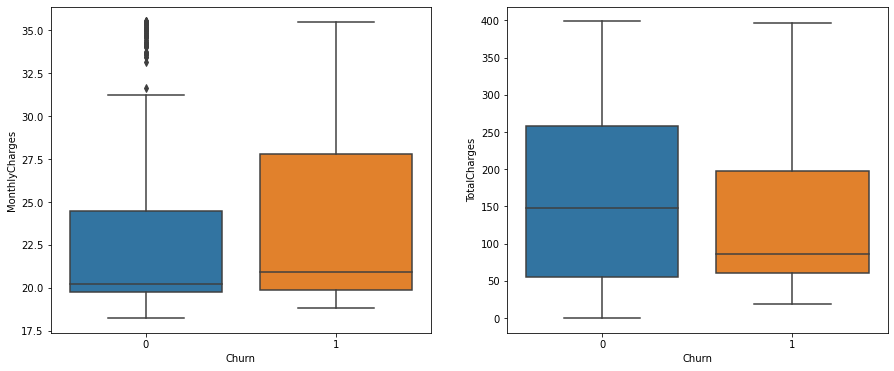

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

sns.boxplot(x='Churn', y='MonthlyCharges', data=raw_data[raw_data['MonthlyCharges'] <= Q1[0]], ax=ax[0])
sns.boxplot(x='Churn', y='TotalCharges', data=raw_data[raw_data['TotalCharges'] <= Q1[1]], ax=ax[1])

<AxesSubplot:xlabel='Churn', ylabel='TotalCharges'>

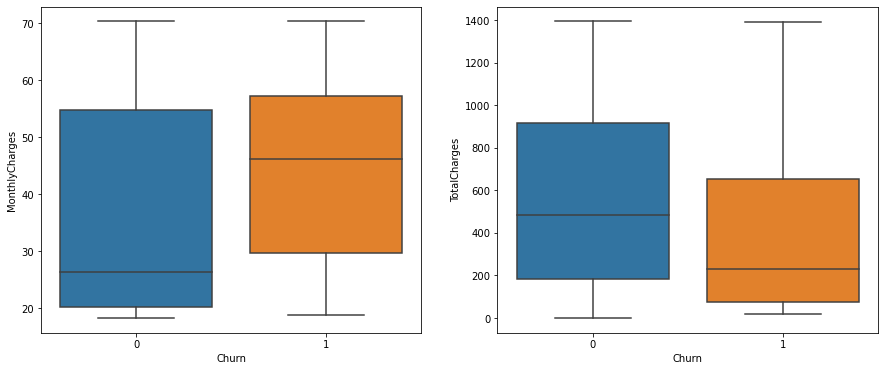

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

sns.boxplot(x='Churn', y='MonthlyCharges', data=raw_data[raw_data['MonthlyCharges'] <= Q2[0]], ax=ax[0])
sns.boxplot(x='Churn', y='TotalCharges', data=raw_data[raw_data['TotalCharges'] <= Q2[1]], ax=ax[1])

<AxesSubplot:xlabel='Churn', ylabel='TotalCharges'>

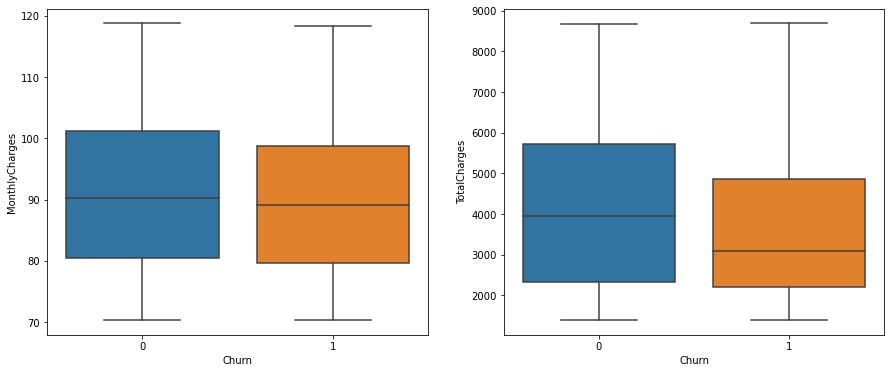

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

sns.boxplot(x='Churn', y='MonthlyCharges', data=raw_data[raw_data['MonthlyCharges'] >= Q2[0]], ax=ax[0])
sns.boxplot(x='Churn', y='TotalCharges', data=raw_data[raw_data['TotalCharges'] >= Q2[1]], ax=ax[1])

<AxesSubplot:xlabel='Churn', ylabel='TotalCharges'>

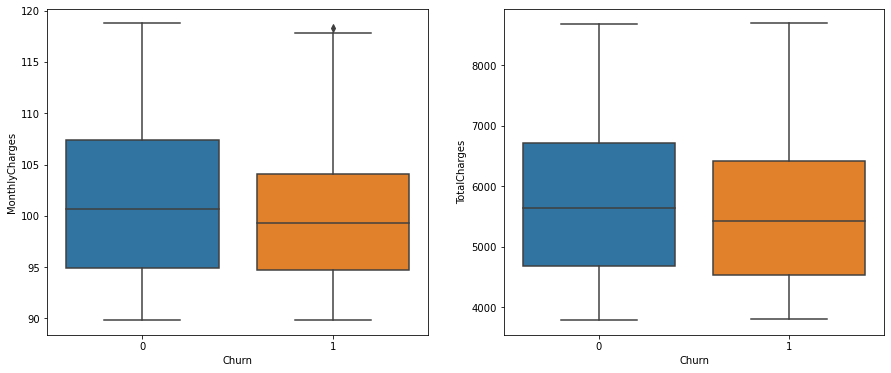

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

sns.boxplot(x='Churn', y='MonthlyCharges', data=raw_data[raw_data['MonthlyCharges'] >= Q3[0]], ax=ax[0])
sns.boxplot(x='Churn', y='TotalCharges', data=raw_data[raw_data['TotalCharges'] >= Q3[1]], ax=ax[1])

<AxesSubplot:xlabel='TotalCharges', ylabel='Density'>

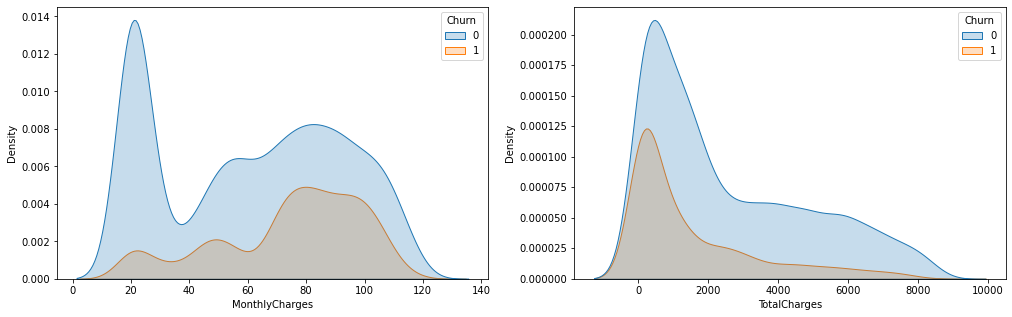

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(17,5))

sns.kdeplot(x='MonthlyCharges', hue='Churn', data=raw_data, shade=True, ax=ax[0])
sns.kdeplot(x='TotalCharges', hue='Churn', data=raw_data, shade=True, ax=ax[1])

- Những người có xu hướng rời đi cung cấp doanh thu cho công ty thấp hơn rất nhiều
- Có thể thấy được những trung bình số tiền chi tiêu theo tháng của những người có xu hướng rời đi lại cao hơn những người có xu hướng ở lại với công ty

## `Num of Services`

In [64]:
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,"1,889.500",0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,"1,840.750",0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1


In [65]:
# Bỏ `Contract` và `PaymentMethod`
temp_data = raw_data.copy()

temp_data['PhoneService'] = temp_data['PhoneService'].map({'Yes':1, 'No':0})
temp_data['MultipleLines'] = temp_data['MultipleLines'].map({'No phone service':0, 'No':0, 'Yes':1})
temp_data['InternetService'] = temp_data['InternetService'].map({'DSL':1, 'Fiber optic':1, 'No':0})
temp_data['OnlineSecurity'] = temp_data['OnlineSecurity'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['OnlineBackup'] = temp_data['OnlineBackup'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['DeviceProtection'] = temp_data['DeviceProtection'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['TechSupport'] = temp_data['TechSupport'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['StreamingTV'] = temp_data['StreamingTV'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['StreamingMovies'] = temp_data['StreamingMovies'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['PaperlessBilling'] = temp_data['PaperlessBilling'].map({'No':0, 'Yes':1})

In [66]:
temp_data['Num of Services'] = temp_data['PhoneService'] + temp_data['MultipleLines'] + temp_data['InternetService'] + temp_data['OnlineSecurity'] + temp_data['OnlineBackup'] + temp_data['DeviceProtection'] + temp_data['TechSupport'] + temp_data['StreamingTV'] + temp_data['StreamingTV'] + temp_data['PaperlessBilling']

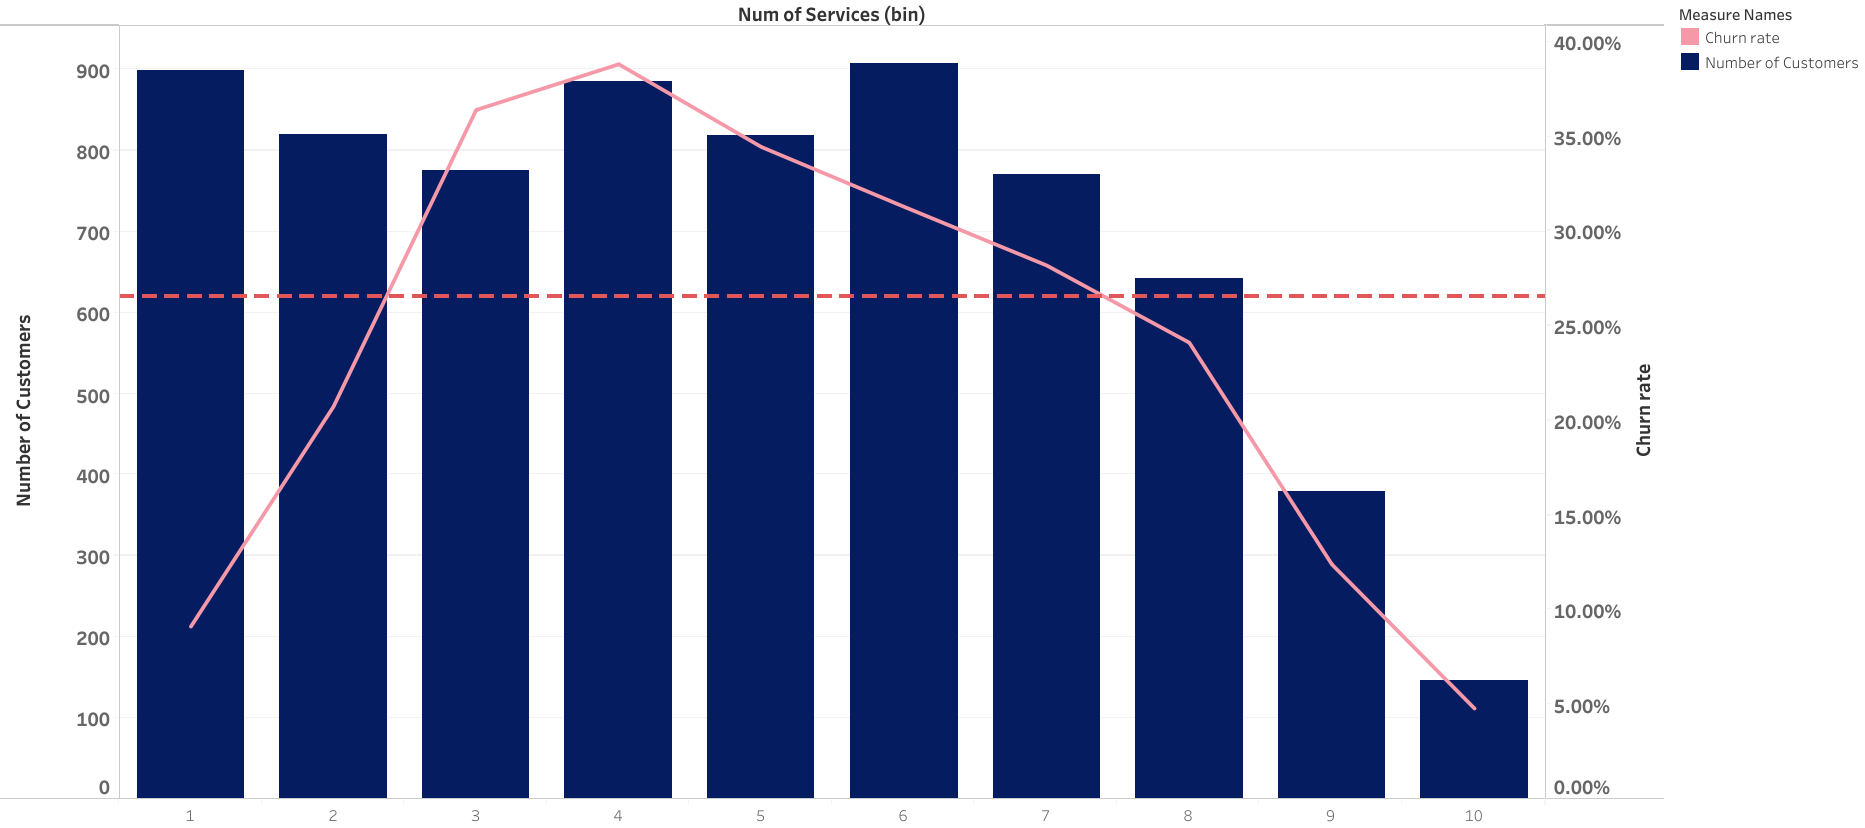

In [67]:
num_of_services_img = Image.open('Images from Tableau/NumOfServices.png')
num_of_services_img

In [68]:
print(temp_data.groupby('Num of Services')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean())

                 tenure  MonthlyCharges  TotalCharges
Num of Services                                      
1                25.058          20.228       502.416
2                26.528          30.340       683.929
3                18.973          53.402       838.780
4                20.889          64.775     1,320.470
5                27.223          72.096     1,915.642
6                34.676          80.819     2,743.676
7                40.688          87.733     3,544.882
8                51.470          94.917     4,883.492
9                60.245         100.338     6,047.262
10               65.068         105.214     6,880.816


- Tỉ lệ người dùng đăng kí chỉ 1 dịch vụ là cao nhất, tỉ lệ người dùng đăng kí đầy đủ 10 dịch vụ là thấp nhất
- Dễ dàng thấy được những người có số lượng dịch vụ đăng kí nhiều hơn sẽ ở lại với công ty lâu hơn cũng như cung cấp doanh thu cho công ty nhiều hơn
- Tỉ lệ rời đi theo số lượng dịch vụ đăng kí lại là biểu đồ hình chuông: người dùng có tỉ lệ rời đi nhiều nhất lại ở khoảng 3-7 dịch vụ được đăng kí
- Ngược lại, những người đăng kí khoảng 1-2 hoặc 8-9 dịch vụ có tỉ lệ rời đi thấp so với nhóm người đăng kí từ 3-7 dịch vụ và nhóm người đăng kí đầy đủ 10 dịch vụ có tỉ lệ rời đi thấp nhất
- Có thể thấy được dù tỉ lệ người dùng đăng kí 10 dịch vụ là thấp nhất nhưng doanh thu thu được từ nhóm người này cao hơn nhóm người đăng kí từ 1-3 dịch vụ hàng tháng. Cùng với đó, mặc dù tỉ lệ người dùng đăng kí chỉ 1 dịch vụ là nhiều nhất nhưng doanh thu mà công ty kiếm được từ họ là thấp nhất
- Doanh thu của nhóm người đăng kí từ 6-9 dịch vụ là cao nhất

# 6. Tiền xử lý dữ liệu

In [69]:
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,"1,889.500",0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,"1,840.750",0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1


##### Tạo features mới

In [70]:
raw_data['Num of Services'] = temp_data['Num of Services']

In [71]:
raw_data['LoyalCustomer'] = raw_data['tenure'].apply(lambda x: 'No' if x < 24 else 'Yes')

##### Drop những feature không quan trọng

In [72]:
raw_data.drop(['customerID'], axis=1, inplace=True)

##### Xử lý features

In [73]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                        'Contract', 'PaperlessBilling', 'PaymentMethod', 'LoyalCustomer']
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Num of Services']

data = pd.get_dummies(raw_data, columns=categorical_features, drop_first=True)

In [74]:
cat_after_onehot = ['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic','InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'LoyalCustomer_Yes']
num_after_onehot = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Num of Services']

def cramers_corrected_stat(i):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    contingency_table=pd.crosstab(data[i], data['Churn'])
    chi2_stat=stats.chi2_contingency(contingency_table)
    n=contingency_table.sum().sum()
    r,k=contingency_table.shape
    phi2=chi2_stat[0]/n
    cramer_corr=np.sqrt(phi2/min(k-1, r-1))
    phi2_corr = max(0, phi2 - (((k-1)*(r-1))/(n-1)))    
    r_corr=r - (((r-1)**2)/(n-1))
    k_corr=k - (((k-1)**2)/(n-1))
    return np.sqrt(phi2_corr/min(k_corr-1, r_corr-1))

def one_way_anova_pvalue_stat(i):
    df_target_0 = data[data['Churn'] == 0]
    df_target_1 = data[data['Churn'] == 1]
    return stats.f_oneway(df_target_0[i], df_target_1[i])[1]

In [75]:
cat_corr = []
for i in cat_after_onehot:
    cat_corr.append(cramers_corrected_stat(i))

cat_df = pd.DataFrame(data=cat_corr, index=cat_after_onehot, columns=['Correlation'])
cat_df.sort_values(by='Correlation')

,Correlation
gender_Male,0.000
MultipleLines_No phone service,0.000
PhoneService_Yes,0.000
MultipleLines_Yes,0.038
StreamingMovies_Yes,0.060
StreamingTV_Yes,0.062
DeviceProtection_Yes,0.065
OnlineBackup_Yes,0.081
PaymentMethod_Mailed check,0.091
PaymentMethod_Credit card (automatic),0.133


In [76]:
num_corr = []
for i in num_after_onehot:
    num_corr.append(one_way_anova_pvalue_stat(i))

num_df = pd.DataFrame(data=num_corr, index=num_after_onehot, columns=['Pvalue'])
num_df.sort_values(by='Pvalue', ascending=False)

,Pvalue
Num of Services,0.094
MonthlyCharges,0.000
TotalCharges,0.000
tenure,0.000


- Bằng những phương pháp thống kê, chúng ta có thể kết luận rằng những trường `gender_Male`, `MultipleLines_No phone service`, `PhoneService_Yes` và `Num of Services` không ảnh hưởng đến trường mục tiêu `Churn`
- Nhưng thay vì drop những trường này, chúng ta hãy giữ lại vì đây là một bộ dữ liệu nhỏ và cũng như vì cách chúng ta chọn mô hình trong phần `Xây dựng mô hình`

##### Kiểm tra độ tương quan giữa nhưng trường thành phần

In [77]:
corr = data.corr()
corr.style.format(precision=2)
corr.style.background_gradient(cmap='coolwarm')

,tenure,MonthlyCharges,TotalCharges,Churn,Num of Services,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,LoyalCustomer_Yes
tenure,1.000000,0.247900,0.826178,-0.352229,0.434600,0.005106,0.016567,0.379697,0.159712,0.008448,-0.008448,0.331941,0.019720,-0.039062,-0.039062,0.327203,-0.039062,0.360277,-0.039062,0.360653,-0.039062,0.324221,-0.039062,0.279756,-0.039062,0.286111,0.202570,0.558533,0.006152,0.233006,-0.208363,-0.233852,0.861296
MonthlyCharges,0.247900,1.000000,0.651174,0.193356,0.850026,-0.014569,0.220173,0.096848,-0.113890,0.247398,-0.247398,0.490434,0.787066,-0.763557,-0.763557,0.296594,-0.763557,0.441780,-0.763557,0.482692,-0.763557,0.338304,-0.763557,0.629603,-0.763557,0.627429,0.004904,-0.074681,0.352150,0.030550,0.271625,-0.377437,0.210016
TotalCharges,0.826178,0.651174,1.000000,-0.198324,0.742140,-0.000080,0.103006,0.317504,0.062078,0.113214,-0.113214,0.468504,0.361655,-0.375223,-0.375223,0.411651,-0.375223,0.509226,-0.375223,0.521983,-0.375223,0.431883,-0.375223,0.514973,-0.375223,0.520122,0.170814,0.354481,0.158574,0.182915,-0.059246,-0.295758,0.692060
Churn,-0.352229,0.193356,-0.198324,1.000000,0.019960,-0.008612,0.150889,-0.150448,-0.164221,0.011942,-0.011942,0.040102,0.308020,-0.227890,-0.227890,-0.171226,-0.227890,-0.082255,-0.227890,-0.066160,-0.227890,-0.164674,-0.227890,0.063228,-0.227890,0.061382,-0.177820,-0.302253,0.191825,-0.134302,0.301919,-0.091683,-0.311496
Num of Services,0.434600,0.850026,0.742140,0.019960,1.000000,-0.016632,0.135982,0.177982,-0.022956,0.081188,-0.081188,0.506073,0.427966,-0.671590,-0.671590,0.478889,-0.671590,0.579163,-0.671590,0.619544,-0.671590,0.540146,-0.671590,0.753851,-0.671590,0.573792,0.076802,0.114425,0.417455,0.103673,0.118319,-0.331161,0.363852
gender_Male,0.005106,-0.014569,-0.000080,-0.008612,-0.016632,1.000000,-0.001874,-0.001808,0.010517,-0.006488,0.006488,-0.008414,-0.011286,0.006026,0.006026,-0.017021,0.006026,-0.013773,0.006026,-0.002105,0.006026,-0.009212,0.006026,-0.008393,0.006026,-0.010487,0.008026,-0.003695,-0.011754,0.001215,0.000752,0.013744,0.006187
SeniorCitizen_1,0.016567,0.220173,0.103006,0.150889,0.135982,-0.001874,1.000000,0.016479,-0.211185,0.008576,-0.008576,0.142948,0.255338,-0.182742,-0.182742,-0.038653,-0.182742,0.066572,-0.182742,0.059428,-0.182742,-0.060625,-0.182742,0.105378,-0.182742,0.120176,-0.046262,-0.117000,0.156530,-0.024135,0.171718,-0.153477,0.025788
Partner_Yes,0.379697,0.096848,0.317504,-0.150448,0.177982,-0.001808,0.016479,1.000000,0.452676,0.017706,-0.017706,0.142057,0.000304,0.000615,0.000615,0.143106,0.000615,0.141498,0.000615,0.153786,0.000615,0.119999,0.000615,0.124666,0.000615,0.117412,0.082783,0.248091,-0.014877,0.082029,-0.083852,-0.095125,0.318147
Dependents_Yes,0.159712,-0.113890,0.062078,-0.164221,-0.022956,0.010517,-0.211185,0.452676,1.000000,-0.001762,0.001762,-0.024526,-0.165818,0.139812,0.139812,0.080972,0.139812,0.023671,0.139812,0.013963,0.139812,0.063268,0.139812,-0.016558,0.139812,-0.039741,0.068368,0.204613,-0.111377,0.060267,-0.150642,0.059071,0.132625
PhoneService_Yes,0.008448,0.247398,0.113214,0.011942,0.081188,-0.006488,0.008576,0.017706,-0.001762,1.000000,-1.000000,0.279690,0.289999,0.172209,0.172209,-0.092893,0.172209,-0.052312,0.172209,-0.071227,0.172209,-0.096340,0.172209,-0.022574,0.172209,-0.032959,-0.002791,0.003519,0.016505,-0.007721,0.003062,-0.003319,-0.001676


Có thể thấy được một số trường dữ liệu bị trùng nhau với độ tương quan tuyệt đối. Hãy drop những feature này

In [78]:
data.drop(['OnlineSecurity_No internet service', 
           'OnlineBackup_No internet service', 'DeviceProtection_No internet service',  
           'TechSupport_No internet service', 'StreamingTV_No internet service', 
           'StreamingMovies_No internet service', 'MultipleLines_No phone service'], axis=1, inplace=True)
corr = data.corr()
corr.style.format(precision=2)
corr.style.background_gradient(cmap='coolwarm')

,tenure,MonthlyCharges,TotalCharges,Churn,Num of Services,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,LoyalCustomer_Yes
tenure,1.000000,0.247900,0.826178,-0.352229,0.434600,0.005106,0.016567,0.379697,0.159712,0.008448,0.331941,0.019720,-0.039062,0.327203,0.360277,0.360653,0.324221,0.279756,0.286111,0.202570,0.558533,0.006152,0.233006,-0.208363,-0.233852,0.861296
MonthlyCharges,0.247900,1.000000,0.651174,0.193356,0.850026,-0.014569,0.220173,0.096848,-0.113890,0.247398,0.490434,0.787066,-0.763557,0.296594,0.441780,0.482692,0.338304,0.629603,0.627429,0.004904,-0.074681,0.352150,0.030550,0.271625,-0.377437,0.210016
TotalCharges,0.826178,0.651174,1.000000,-0.198324,0.742140,-0.000080,0.103006,0.317504,0.062078,0.113214,0.468504,0.361655,-0.375223,0.411651,0.509226,0.521983,0.431883,0.514973,0.520122,0.170814,0.354481,0.158574,0.182915,-0.059246,-0.295758,0.692060
Churn,-0.352229,0.193356,-0.198324,1.000000,0.019960,-0.008612,0.150889,-0.150448,-0.164221,0.011942,0.040102,0.308020,-0.227890,-0.171226,-0.082255,-0.066160,-0.164674,0.063228,0.061382,-0.177820,-0.302253,0.191825,-0.134302,0.301919,-0.091683,-0.311496
Num of Services,0.434600,0.850026,0.742140,0.019960,1.000000,-0.016632,0.135982,0.177982,-0.022956,0.081188,0.506073,0.427966,-0.671590,0.478889,0.579163,0.619544,0.540146,0.753851,0.573792,0.076802,0.114425,0.417455,0.103673,0.118319,-0.331161,0.363852
gender_Male,0.005106,-0.014569,-0.000080,-0.008612,-0.016632,1.000000,-0.001874,-0.001808,0.010517,-0.006488,-0.008414,-0.011286,0.006026,-0.017021,-0.013773,-0.002105,-0.009212,-0.008393,-0.010487,0.008026,-0.003695,-0.011754,0.001215,0.000752,0.013744,0.006187
SeniorCitizen_1,0.016567,0.220173,0.103006,0.150889,0.135982,-0.001874,1.000000,0.016479,-0.211185,0.008576,0.142948,0.255338,-0.182742,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,-0.046262,-0.117000,0.156530,-0.024135,0.171718,-0.153477,0.025788
Partner_Yes,0.379697,0.096848,0.317504,-0.150448,0.177982,-0.001808,0.016479,1.000000,0.452676,0.017706,0.142057,0.000304,0.000615,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,0.082783,0.248091,-0.014877,0.082029,-0.083852,-0.095125,0.318147
Dependents_Yes,0.159712,-0.113890,0.062078,-0.164221,-0.022956,0.010517,-0.211185,0.452676,1.000000,-0.001762,-0.024526,-0.165818,0.139812,0.080972,0.023671,0.013963,0.063268,-0.016558,-0.039741,0.068368,0.204613,-0.111377,0.060267,-0.150642,0.059071,0.132625
PhoneService_Yes,0.008448,0.247398,0.113214,0.011942,0.081188,-0.006488,0.008576,0.017706,-0.001762,1.000000,0.279690,0.289999,0.172209,-0.092893,-0.052312,-0.071227,-0.096340,-0.022574,-0.032959,-0.002791,0.003519,0.016505,-0.007721,0.003062,-0.003319,-0.001676


##### Phân chia và chuẩn hóa dữ liệu

In [79]:
X = data.drop('Churn', axis=1)
y = data['Churn']

X.shape, y.shape

((7043, 25), (7043,))

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1713, stratify=y)

scaler = MinMaxScaler()

X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

X_train_scale[numerical_features] = scaler.fit_transform(X_train_scale[numerical_features])
X_test_scale[numerical_features] = scaler.transform(X_test_scale[numerical_features])

# 7. Xây dựng mô hình

In [81]:
data['Churn'].value_counts(normalize=True)

0   0.735
1   0.265
Name: Churn, dtype: float64

Đây là 1 bộ dữ liệu mất cân bằng với `26.54%` cho class 1

### Case 1: Dữ liệu thuần

### Case 2: Class weight

### Case 3: Downsampling = NearMiss

In [82]:
nm = NearMiss()

X_train_nm, y_train_nm = nm.fit_resample(X_train_scale, y_train)
X_train_nm.shape, y_train_nm.shape

((2990, 25), (2990,))

### Case 4: Upsampling = SMOTE

In [83]:
smote = SMOTE(k_neighbors=5)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scale, y_train)
X_train_smote.shape, y_train_smote.shape

((8278, 25), (8278,))

In [84]:
def logistic_model(X_train_temp, X_test_temp, y_train_temp, class_weight=None):
    logistic_model = LogisticRegression(class_weight=class_weight)
    logistic_model.fit(X_train_temp, y_train_temp)

    yhat = logistic_model.predict(X_test_temp)
    yhat_proba = logistic_model.predict_proba(X_test_temp)
    
    return yhat, yhat_proba
    
def rfc_model(X_train_temp, X_test_temp, y_train_temp, class_weight=None):
    rfc_model = RandomForestClassifier(class_weight=class_weight)
    rfc_model.fit(X_train_temp, y_train_temp)

    yhat = rfc_model.predict(X_test_temp)
    yhat_proba = rfc_model.predict_proba(X_test_temp)
    
    return yhat, yhat_proba
    
def xgb_model(X_train_temp, X_test_temp, y_train_temp, class_weight=None):
    xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='mlogloss', class_weight=class_weight)
    xgb_model.fit(X_train_temp, y_train_temp)

    yhat = xgb_model.predict(X_test_temp)
    yhat_proba = xgb_model.predict_proba(X_test_temp)
    return yhat, yhat_proba

def lgbm_model(X_train_temp, X_test_temp, y_train_temp, class_weight=None):
    lgbm_model = LGBMClassifier(class_weight=class_weight)
    lgbm_model.fit(X_train_temp, y_train_temp)

    yhat = lgbm_model.predict(X_test_temp)
    yhat_proba = lgbm_model.predict_proba(X_test_temp)
    return yhat, yhat_proba

# 8. Đánh giá hiệu năng mô hình

In [85]:
def display_confusion_matrix(model, X, y, labels=None):
    plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues, display_labels=labels)
    plt.grid(False)     
    plt.tight_layout()

In [86]:
def display_classification_report(y_true, yhat):
    print(pd.DataFrame(confusion_matrix(y_true, yhat), 
                       columns=['Retain Pred', 'Churn Pred'], 
                       index=['Retain Actual', 'Churn Actual']))
    print('======================================================')
    print(classification_report(y_true, yhat))

##### LogisticRegression

In [87]:
print('=============================CASE 1=============================')
log_yhat_1, log_yhat_proba_1 = logistic_model(X_train_scale, X_test_scale, y_train)
display_classification_report(y_test, log_yhat_1)

print('=============================CASE 2=============================')
log_yhat_2, log_yhat_proba_2 = logistic_model(X_train_scale, X_test_scale, y_train, class_weight='balanced')
display_classification_report(y_test, log_yhat_2)

print('=============================CASE 3=============================')
log_yhat_3, log_yhat_proba_3 = logistic_model(X_train_nm, X_test_scale, y_train_nm)
display_classification_report(y_test, log_yhat_3)

print('=============================CASE 4=============================')
log_yhat_4, log_yhat_proba_4 = logistic_model(X_train_smote, X_test_scale, y_train_smote)
display_classification_report(y_test, log_yhat_4)

=============================CASE 1=============================
               Retain Pred  Churn Pred
Retain Actual          935         100
Churn Actual           170         204
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.67      0.55      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409

=============================CASE 2=============================
               Retain Pred  Churn Pred
Retain Actual          755         280
Churn Actual            68         306
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1035
           1       0.52      0.82      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75    

##### RandomForestClassifier

In [88]:
print('=============================CASE 1=============================')
rfc_yhat_1, rfc_yhat_proba_1 = rfc_model(X_train_scale, X_test_scale, y_train)
display_classification_report(y_test, rfc_yhat_1)

print('=============================CASE 2=============================')
rfc_yhat_2, rfc_yhat_proba_2 = rfc_model(X_train_scale, X_test_scale, y_train, class_weight='balanced')
display_classification_report(y_test, rfc_yhat_2)

print('=============================CASE 3=============================')
rfc_yhat_3, rfc_yhat_proba_3 = rfc_model(X_train_nm, X_test_scale, y_train_nm)
display_classification_report(y_test, rfc_yhat_3)

print('=============================CASE 4=============================')
rfc_yhat_4, rfc_yhat_proba_4 = rfc_model(X_train_smote, X_test_scale, y_train_smote)
display_classification_report(y_test, rfc_yhat_4)

=============================CASE 1=============================
               Retain Pred  Churn Pred
Retain Actual          948          87
Churn Actual           192         182
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.68      0.49      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

=============================CASE 2=============================
               Retain Pred  Churn Pred
Retain Actual          950          85
Churn Actual           194         180
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.68      0.48      0.56       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80    

##### XGBClassifier

In [89]:
print('=============================CASE 1=============================')
xgb_yhat_1, xgb_yhat_proba_1 = xgb_model(X_train_scale, X_test_scale, y_train)
display_classification_report(y_test, xgb_yhat_1)

print('=============================CASE 2=============================')
xgb_yhat_2, xgb_yhat_proba_2 = xgb_model(X_train_scale, X_test_scale, y_train, class_weight='balanced')
display_classification_report(y_test, xgb_yhat_2)

print('=============================CASE 3=============================')
xgb_yhat_3, xgb_yhat_proba_3 = xgb_model(X_train_nm, X_test_scale, y_train_nm)
display_classification_report(y_test, xgb_yhat_3)

print('=============================CASE 4=============================')
xgb_yhat_4, xgb_yhat_proba_4 = xgb_model(X_train_smote, X_test_scale, y_train_smote)
display_classification_report(y_test, xgb_yhat_4)

=============================CASE 1=============================
               Retain Pred  Churn Pred
Retain Actual          920         115
Churn Actual           184         190
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

=============================CASE 2=============================
[21:12:52] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


               Retain Pred

##### LGBMClassifier

In [90]:
print('=============================CASE 1=============================')
lgbm_yhat_1, lgbm_yhat_proba_1 = lgbm_model(X_train_scale, X_test_scale, y_train)
display_classification_report(y_test, lgbm_yhat_1)

print('=============================CASE 2=============================')
lgbm_yhat_2, lgbm_yhat_proba_2 = lgbm_model(X_train_scale, X_test_scale, y_train, class_weight='balanced')
display_classification_report(y_test, lgbm_yhat_2)

print('=============================CASE 3=============================')
lgbm_yhat_3, lgbm_yhat_proba_3 = lgbm_model(X_train_nm, X_test_scale, y_train_nm)
display_classification_report(y_test, lgbm_yhat_3)

print('=============================CASE 4=============================')
lgbm_yhat_4, lgbm_yhat_proba_4 = lgbm_model(X_train_smote, X_test_scale, y_train_smote)
display_classification_report(y_test, lgbm_yhat_4)

=============================CASE 1=============================
               Retain Pred  Churn Pred
Retain Actual          935         100
Churn Actual           187         187
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

=============================CASE 2=============================
               Retain Pred  Churn Pred
Retain Actual          795         240
Churn Actual            85         289
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.55      0.77      0.64       374

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.74      1409
weighted avg       0.81      0.77    

##### ROC AUL & Precision-Recall AUL

In [91]:
def plot_ROC_curve(y_test, model):
    if model == 'logistic':
        fpr1, tpr1, _ = roc_curve(y_test, log_yhat_proba_1[:, 1])
        fpr2, tpr2, _ = roc_curve(y_test, log_yhat_proba_2[:, 1])
        fpr3, tpr3, _ = roc_curve(y_test, log_yhat_proba_3[:, 1])
        fpr4, tpr4, _ = roc_curve(y_test, log_yhat_proba_4[:, 1]) 
        print('Case 1: %.2f' % roc_auc_score(y_test, log_yhat_proba_1[:, 1]))
        print('Case 2: %.2f' % roc_auc_score(y_test, log_yhat_proba_2[:, 1]))
        print('Case 3: %.2f' % roc_auc_score(y_test, log_yhat_proba_3[:, 1]))
        print('Case 4: %.2f' % roc_auc_score(y_test, log_yhat_proba_4[:, 1]))
    elif model == 'rfc':
        fpr1, tpr1, _ = roc_curve(y_test, rfc_yhat_proba_1[:, 1])
        fpr2, tpr2, _ = roc_curve(y_test, rfc_yhat_proba_2[:, 1])
        fpr3, tpr3, _ = roc_curve(y_test, rfc_yhat_proba_3[:, 1])
        fpr4, tpr4, _ = roc_curve(y_test, rfc_yhat_proba_4[:, 1])
        print('Case 1: %.2f' % roc_auc_score(y_test, rfc_yhat_proba_1[:, 1]))
        print('Case 2: %.2f' % roc_auc_score(y_test, rfc_yhat_proba_2[:, 1]))
        print('Case 3: %.2f' % roc_auc_score(y_test, rfc_yhat_proba_3[:, 1]))
        print('Case 4: %.2f' % roc_auc_score(y_test, rfc_yhat_proba_4[:, 1]))
    elif model == 'lgbm':
        fpr1, tpr1, _ = roc_curve(y_test, lgbm_yhat_proba_1[:, 1])
        fpr2, tpr2, _ = roc_curve(y_test, lgbm_yhat_proba_2[:, 1])
        fpr3, tpr3, _ = roc_curve(y_test, lgbm_yhat_proba_3[:, 1])
        fpr4, tpr4, _ = roc_curve(y_test, lgbm_yhat_proba_4[:, 1])
        print('Case 1: %.2f' % roc_auc_score(y_test, lgbm_yhat_proba_1[:, 1]))
        print('Case 2: %.2f' % roc_auc_score(y_test, lgbm_yhat_proba_2[:, 1]))
        print('Case 3: %.2f' % roc_auc_score(y_test, lgbm_yhat_proba_3[:, 1]))
        print('Case 4: %.2f' % roc_auc_score(y_test, lgbm_yhat_proba_4[:, 1]))
    else:
        fpr1, tpr1, _ = roc_curve(y_test, xgb_yhat_proba_1[:, 1])
        fpr2, tpr2, _ = roc_curve(y_test, xgb_yhat_proba_2[:, 1])
        fpr3, tpr3, _ = roc_curve(y_test, xgb_yhat_proba_3[:, 1])
        fpr4, tpr4, _ = roc_curve(y_test, xgb_yhat_proba_4[:, 1])
        print('Case 1: %.2f' % roc_auc_score(y_test, xgb_yhat_proba_1[:, 1]))
        print('Case 2: %.2f' % roc_auc_score(y_test, xgb_yhat_proba_2[:, 1]))
        print('Case 3: %.2f' % roc_auc_score(y_test, xgb_yhat_proba_3[:, 1]))
        print('Case 4: %.2f' % roc_auc_score(y_test, xgb_yhat_proba_4[:, 1]))
        
    plt.figure(figsize=(12,8))
    
    ns_proba = [0 for i in range(len(y_test))]
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_proba)
    
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='NoSkill')
    plt.plot(fpr1, tpr1, marker='.', label='Case 1')
    plt.plot(fpr2, tpr2, marker='.', label='Case 2')
    plt.plot(fpr3, tpr3, marker='.', label='Case 3')
    plt.plot(fpr4, tpr4, marker='.', label='Case 4')   
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

In [92]:
def plot_PR_curve(y_test, model):
    if model == 'logistic':
        p1, r1, _ = precision_recall_curve(y_test, log_yhat_proba_1[:, 1])
        p2, r2, _ = precision_recall_curve(y_test, log_yhat_proba_2[:, 1])
        p3, r3, _ = precision_recall_curve(y_test, log_yhat_proba_3[:, 1])
        p4, r4, _ = precision_recall_curve(y_test, log_yhat_proba_4[:, 1])
        print('Case 1: %.2f' % auc(r1, p1))
        print('Case 2: %.2f' % auc(r2, p2))
        print('Case 3: %.2f' % auc(r3, p3))
        print('Case 4: %.2f' % auc(r4, p4))
    elif model == 'rfc':
        p1, r1, _ = precision_recall_curve(y_test, rfc_yhat_proba_1[:, 1])
        p2, r2, _ = precision_recall_curve(y_test, rfc_yhat_proba_2[:, 1])
        p3, r3, _ = precision_recall_curve(y_test, rfc_yhat_proba_3[:, 1])
        p4, r4, _ = precision_recall_curve(y_test, rfc_yhat_proba_4[:, 1])
        print('Case 1: %.2f' % auc(r1, p1))
        print('Case 2: %.2f' % auc(r2, p2))
        print('Case 3: %.2f' % auc(r3, p3))
        print('Case 4: %.2f' % auc(r4, p4))
    elif model == 'lgbm':
        p1, r1, _ = precision_recall_curve(y_test, lgbm_yhat_proba_1[:, 1])
        p2, r2, _ = precision_recall_curve(y_test, lgbm_yhat_proba_2[:, 1])
        p3, r3, _ = precision_recall_curve(y_test, lgbm_yhat_proba_3[:, 1])
        p4, r4, _ = precision_recall_curve(y_test, lgbm_yhat_proba_4[:, 1])
        print('Case 1: %.2f' % auc(r1, p1))
        print('Case 2: %.2f' % auc(r2, p2))
        print('Case 3: %.2f' % auc(r3, p3))
        print('Case 4: %.2f' % auc(r4, p4))
    else:
        p1, r1, _ = precision_recall_curve(y_test, xgb_yhat_proba_1[:, 1])
        p2, r2, _ = precision_recall_curve(y_test, xgb_yhat_proba_2[:, 1])
        p3, r3, _ = precision_recall_curve(y_test, xgb_yhat_proba_3[:, 1])
        p4, r4, _ = precision_recall_curve(y_test, xgb_yhat_proba_4[:, 1])
        print('Case 1: %.2f' % auc(r1, p1))
        print('Case 2: %.2f' % auc(r2, p2))
        print('Case 3: %.2f' % auc(r3, p3))
        print('Case 4: %.2f' % auc(r4, p4))
    
    no_skill = len(y_test[y_test == 1]) / len(y_test)
    
    plt.figure(figsize=(12,8))
    
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='NoSkill')
    plt.plot(r1, p1, marker='.', label='Case 1')
    plt.plot(r2, p2, marker='.', label='Case 2')
    plt.plot(r3, p3, marker='.', label='Case 3')
    plt.plot(r4, p4, marker='.', label='Case 4')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

##### LogisticRegression

Case 1: 0.86
Case 2: 0.86
Case 3: 0.79
Case 4: 0.85


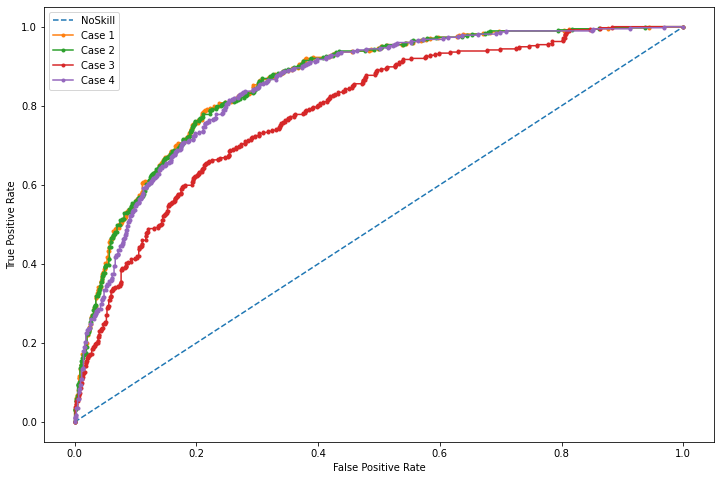

In [93]:
plot_ROC_curve(y_test, 'logistic')

Case 1: 0.68
Case 2: 0.68
Case 3: 0.57
Case 4: 0.65


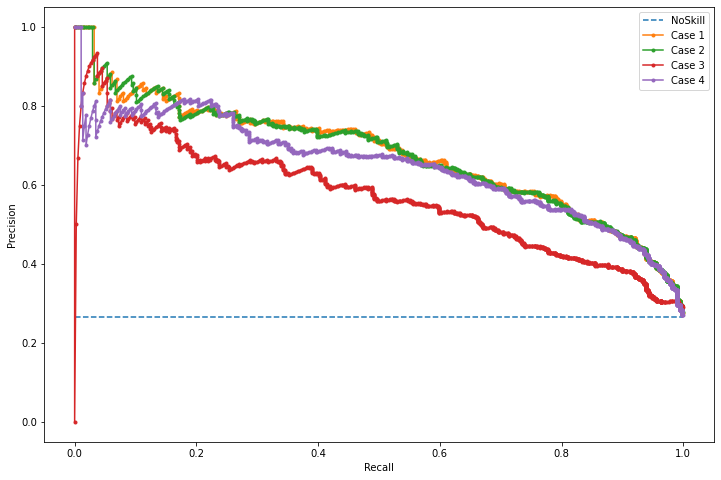

In [94]:
plot_PR_curve(y_test, 'logistic')

##### RandomForestClassifier

Case 1: 0.84
Case 2: 0.84
Case 3: 0.65
Case 4: 0.84


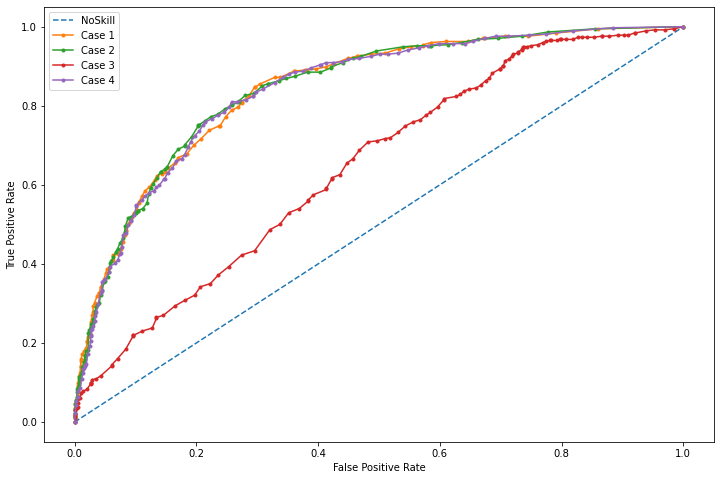

In [95]:
plot_ROC_curve(y_test, 'rfc')

Case 1: 0.66
Case 2: 0.65
Case 3: 0.40
Case 4: 0.64


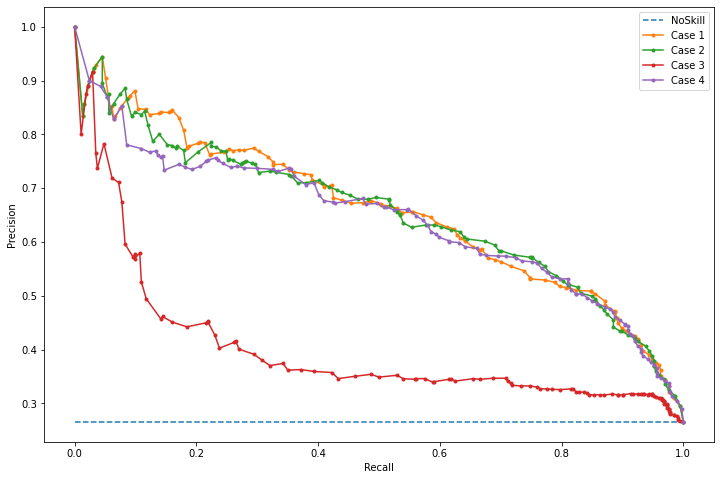

In [96]:
plot_PR_curve(y_test, 'rfc')

##### XGBClassifier

Case 1: 0.83
Case 2: 0.83
Case 3: 0.61
Case 4: 0.84


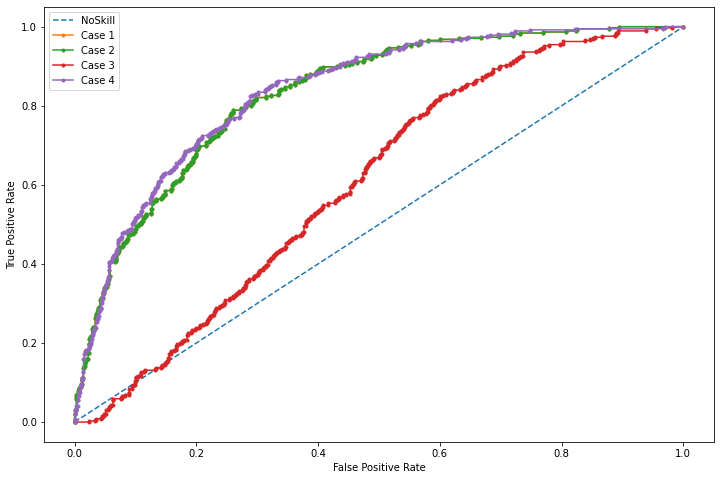

In [97]:
plot_ROC_curve(y_test, 'xgb')

Case 1: 0.63
Case 2: 0.63
Case 3: 0.30
Case 4: 0.63


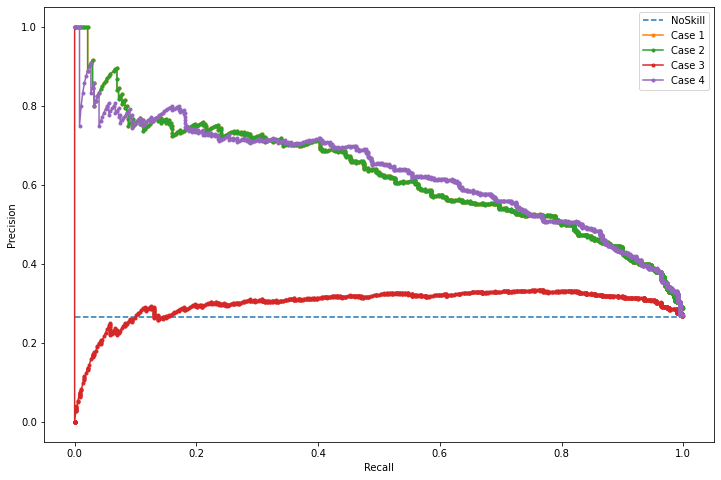

In [98]:
plot_PR_curve(y_test, 'xgb')

##### LGBMClassifier

Case 1: 0.84
Case 2: 0.85
Case 3: 0.61
Case 4: 0.85


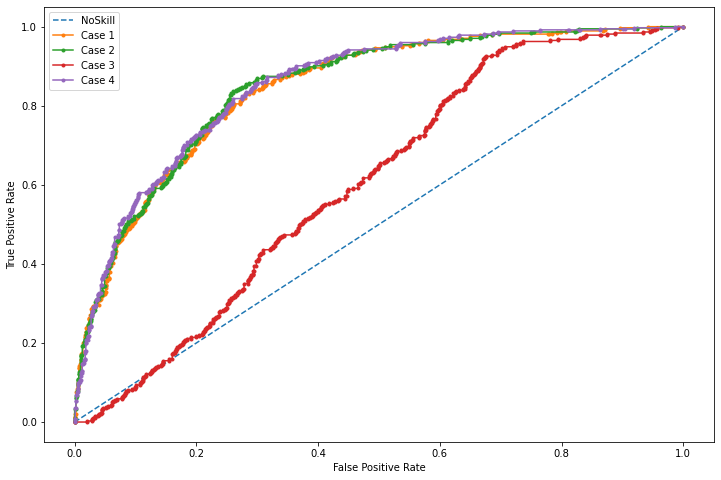

In [99]:
plot_ROC_curve(y_test, 'lgbm')

Case 1: 0.66
Case 2: 0.66
Case 3: 0.30
Case 4: 0.66


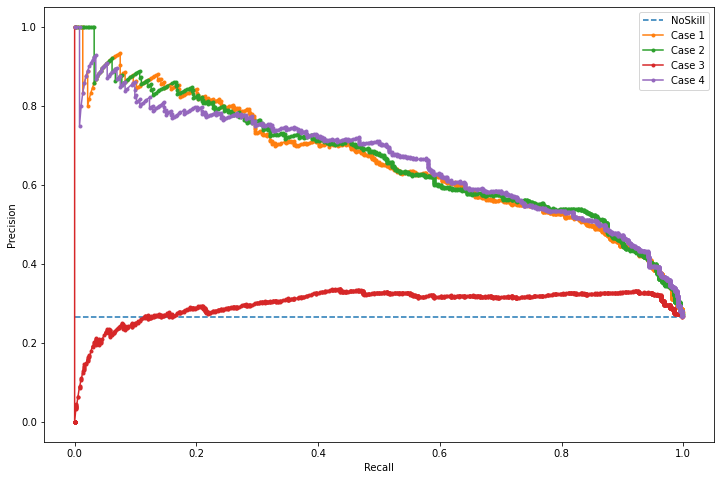

In [100]:
plot_PR_curve(y_test, 'lgbm')

- Downsampling = NearMiss mang lại hiệu quả rất kém 
- Có thể thấy 3 phương pháp còn lại tiệm cận nhau về độ hiệu quả nhưng tiềm năng của `class-weight` còn có thể khai thác thêm

#### Tinh chỉnh CASE 2: `class_weight` để đạt hiệu năng tốt nhất

In [101]:
def building_grid(model, grid_params, refit='roc_auc'):
    scoring = {'roc_auc': make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=False), 
               'accuracy': make_scorer(accuracy_score), 
               'precision': make_scorer(precision_score), 
               'recall': make_scorer(recall_score), 
               'f1': make_scorer(f1_score)
              }
    
    grid = GridSearchCV(estimator=model, 
                        param_grid=grid_params, 
                        scoring=scoring, refit=refit, 
                        cv=StratifiedKFold(n_splits=5, random_state=1713, shuffle=True))
    
    return grid

In [102]:
def showing_grid_metrics(cv_results, sort_by):
    metrics = ['params', 'mean_test_roc_auc', 'mean_test_accuracy', 
               'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 
               'rank_test_roc_auc', 'rank_test_recall']

    cv_results_metrics = cv_results.loc[:, metrics]
    cv_results_metrics.sort_values(by=[sort_by], ascending=False, inplace=True)
    
    return cv_results_metrics[:5]

In [103]:
def feature_importance(model, X_df):
    coef_table = pd.DataFrame(X_df.columns, columns=['feature'])
    coef_table.insert(1, 'coef', model.coef_.transpose())

    fig = plt.figure(figsize=(18, 8))
    sns.barplot(x='feature', y='coef', data=coef_table, palette='vlag')
    plt.title('Model Coefficients by Feature', size=20)
    plt.xlabel('Feature', size=16)
    plt.ylabel('Model Coefficient', size=16)
    plt.xticks(rotation=-80)
    plt.tight_layout()
    
    return coef_table

In [104]:
def score_pred(model, data_type, y_true, yhat, yhat_proba):
    scores = {}
    scores['model'] = model
    scores['data'] = data_type
    scores['roc_auc'] = roc_auc_score(y_true, yhat_proba[:, 1])
    scores['acc'] = accuracy_score(y_true, yhat)
    scores['recall'] = recall_score(y_true, yhat)
    scores['precision'] = precision_score(y_true, yhat)
    scores['f1'] = f1_score(y_true, yhat)   
    print(f'{scores["model"]} Predictions: ROC AUC {round(scores["roc_auc"], 2)} | '
          f'Accuracy {round(scores["acc"], 2)} | '
          f'Precision {round(scores["precision"], 2)} | '
          f'Recall {round(scores["recall"], 2)} | '
          f'F1 {round(scores["f1"], 2)}' )
    return scores

##### LogisticRegression

In [105]:
lr_model = LogisticRegression(random_state=1713, fit_intercept=False, max_iter=2000, n_jobs=-1)

c_params = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
lr_grid_params = [{'C' : c_params, 'solver' : ['liblinear', 'saga'], 
                   'penalty': ['l1', 'l2'], 
                   'class_weight' : [None, 'balanced', {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}]}]

lr_grid = building_grid(lr_model, grid_params=lr_grid_params)
lr_grid.fit(X_train_scale, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1713, shuffle=True),
             estimator=LogisticRegression(fit_intercept=False, max_iter=2000,
                                          n_jobs=-1, random_state=1713),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [None, 'balanced', {0: 0.1, 1: 0.9},
                                           {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7},
                                           {0: 0.4, 1: 0.6}],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [106]:
lr_cv_results = pd.DataFrame.from_dict(lr_grid.cv_results_)
lr_cv_results_metrics = showing_grid_metrics(lr_cv_results, 'mean_test_roc_auc')
lr_cv_results_metrics

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
148,"{'C': 1000, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}",0.761,0.745,0.513,0.795,0.624,1,53
125,"{'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}",0.761,0.745,0.513,0.795,0.624,1,53
100,"{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}",0.761,0.746,0.514,0.793,0.624,3,60
101,"{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}",0.761,0.746,0.514,0.793,0.624,3,60
126,"{'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}",0.761,0.746,0.514,0.794,0.624,5,58


,feature,coef
0,tenure,-3.074
1,MonthlyCharges,7.135
2,TotalCharges,1.600
3,Num of Services,-0.504
4,gender_Male,0.030
5,SeniorCitizen_1,0.233
6,Partner_Yes,0.002
7,Dependents_Yes,-0.197
8,PhoneService_Yes,-1.642
9,MultipleLines_Yes,-0.063


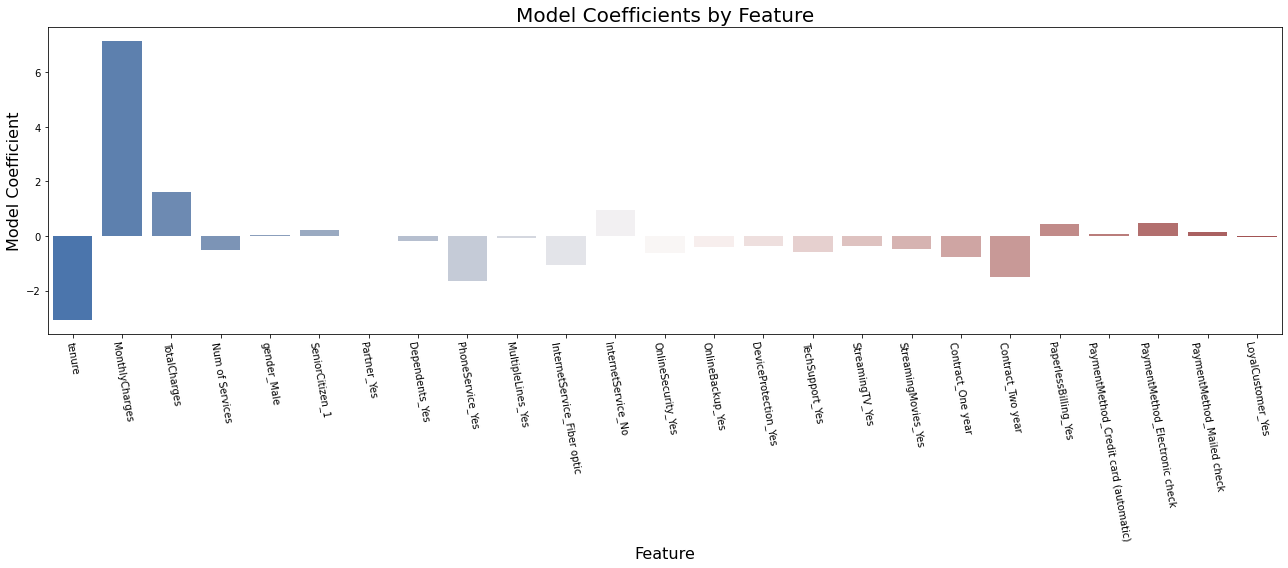

In [107]:
lr_best_model = lr_grid.best_estimator_
feature_importance(lr_best_model, X_train_scale)

In [108]:
print('Train Performance - LogisticRegression\n---------------------------------')
lr_yhat_train = lr_grid.predict(X_train_scale)
lr_yhat_proba_train = lr_grid.predict_proba(X_train_scale)
lr_scores_train= score_pred('LogisticRegression', 'train', y_train, lr_yhat_train, lr_yhat_proba_train)

print('Test Performance - LogisticRegression\n---------------------------------')
lr_yhat_test = lr_grid.predict(X_test_scale)
lr_yhat_proba_test = lr_grid.predict_proba(X_test_scale)
lr_scores_test = score_pred('LogisticRegression', 'test', y_test, lr_yhat_test, lr_yhat_proba_test)

Train Performance - LogisticRegression
---------------------------------
LogisticRegression Predictions: ROC AUC 0.84 | Accuracy 0.75 | Precision 0.52 | Recall 0.8 | F1 0.63
Test Performance - LogisticRegression
---------------------------------
LogisticRegression Predictions: ROC AUC 0.86 | Accuracy 0.76 | Precision 0.52 | Recall 0.82 | F1 0.64


##### RandomRorestClassifier

In [109]:
rf_model = RandomForestClassifier(random_state=1713, n_jobs=-1)

rf_grid_params = [{'criterion': ['gini', 'entropy'], 
                   'class_weight': ['balanced', {0:0.1, 1:0.9}, {0:0.2, 1:0.8}],             
                   'max_depth': [4, 6, 8, 10],  
                   'min_samples_leaf': [5, 10, 15], 
                   'min_samples_split': [0.1, 0.2, 0.3, 0.4],
                   'n_estimators': [500],
                    }]

rf_grid = building_grid(rf_model, rf_grid_params)
rf_grid.fit(X_train_scale, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1713, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1713),
             param_grid=[{'class_weight': ['balanced', {0: 0.1, 1: 0.9},
                                           {0: 0.2, 1: 0.8}],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [4, 6, 8, 10],
                          'min_samples_leaf': [5, 10, 15],
                          'min_samples_split': [0.1, 0.2, 0.3, 0.4],
                          'n_estimators': [500]}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [110]:
rf_cv_results = pd.DataFrame.from_dict(rf_grid.cv_results_)
rf_cv_results_metrics = showing_grid_metrics(rf_cv_results, 'mean_test_roc_auc')
rf_cv_results_metrics

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
68,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 0.1, 'n_estimators': 500}",0.757,0.749,0.518,0.775,0.620,1,217
64,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 0.1, 'n_estimators': 500}",0.757,0.749,0.518,0.774,0.620,2,230
60,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 0.1, 'n_estimators': 500}",0.757,0.749,0.518,0.773,0.620,3,234
92,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 0.1, 'n_estimators': 500}",0.756,0.748,0.517,0.773,0.620,4,232
80,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 0.1, 'n_estimators': 500}",0.756,0.748,0.517,0.773,0.620,4,232


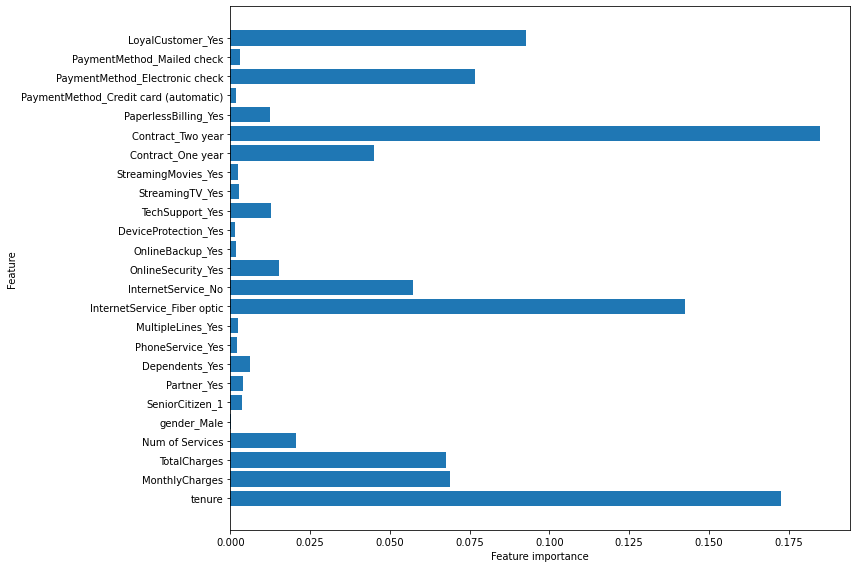

In [111]:
rf_best_model = rf_grid.best_estimator_

n_features = X_train_scale.shape[1]
plt.figure(figsize=(12,8))
plt.barh(range(n_features), rf_best_model.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train_scale.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.tight_layout()

In [112]:
print('Train Performance - RandomForestClassifier ---------------------------------')
rf_yhat_train = rf_grid.predict(X_train_scale)
rf_yhat_proba_train = rf_grid.predict_proba(X_train_scale)
rf_scores_train= score_pred('RandomForestClassifier', 'train', y_train, rf_yhat_train, rf_yhat_proba_train)

print('\nTest Performance - RandomForestClassifier ---------------------------------')
rf_yhat_test = rf_grid.predict(X_test_scale)
rf_yhat_proba_test = rf_grid.predict_proba(X_test_scale)
rf_scores_test = score_pred('RandomForestClassifer', 'test', y_test, rf_yhat_test, rf_yhat_proba_test)

Train Performance - RandomForestClassifier ---------------------------------
RandomForestClassifier Predictions: ROC AUC 0.84 | Accuracy 0.75 | Precision 0.52 | Recall 0.78 | F1 0.63

Test Performance - RandomForestClassifier ---------------------------------
RandomForestClassifer Predictions: ROC AUC 0.85 | Accuracy 0.76 | Precision 0.53 | Recall 0.8 | F1 0.64


##### XGBClassifier 

In [113]:
xg_model = XGBClassifier(seed=1713, objective='binary:logistic', eval_metric='mlogloss')

pos_weight = round(len(y_test[y_test == 0]) / len(y_test[y_test == 1]), 1)
xg_grid_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_lambda': [1, 2], 
    'scale_pos_weight': [pos_weight],
    'max_depth': [4, 6, 8], 
    'subsample': [0.6, 0.8], 
    'colsample_bytree': [0.7, 0.9],
    'gamma': [1, 2, 4],
    'colsample_bytree': [0.7, 0.9],
    'n_estimators': [100, 250, 500],
}

xg_grid = building_grid(xg_model, xg_grid_params)
xg_grid.fit(X_train_scale, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1713, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=...
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 250, 500], 'reg_lambda': [1, 2],
                         'scale_pos_weight': [2.8], 'subsample': [0.6, 0.8]},
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [114]:
xg_cv_results = pd.DataFrame.from_dict(xg_grid.cv_results_)
xg_cv_results_metrics = showing_grid_metrics(xg_cv_results, 'mean_test_roc_auc')
xg_cv_results_metrics

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
12,"{'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 1, 'scale_pos_weight': 2.8, 'subsa...",0.763,0.756,0.528,0.778,0.629,1,97
230,"{'colsample_bytree': 0.7, 'gamma': 4, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 2, 'scale_pos_weight': 2.8, 'subsa...",0.763,0.756,0.527,0.779,0.629,2,91
120,"{'colsample_bytree': 0.7, 'gamma': 2, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 1, 'scale_pos_weight': 2.8, 'subsa...",0.763,0.755,0.527,0.779,0.628,3,86
122,"{'colsample_bytree': 0.7, 'gamma': 2, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 2, 'scale_pos_weight': 2.8, 'subsa...",0.763,0.756,0.527,0.778,0.628,4,95
557,"{'colsample_bytree': 0.9, 'gamma': 4, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 250, 'reg_lambda': 1, 'scale_pos_weight': 2.8, 'subsa...",0.763,0.755,0.526,0.779,0.628,5,89


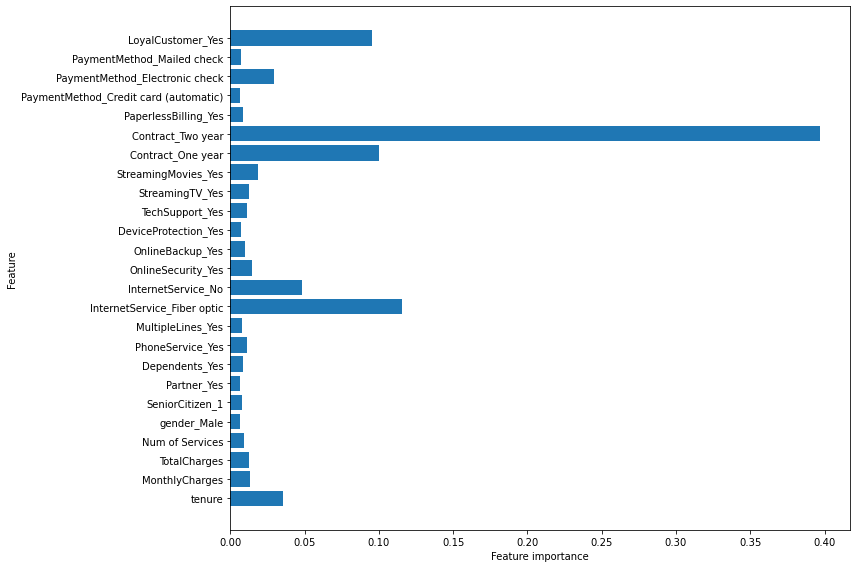

In [115]:
xg_best_model = xg_grid.best_estimator_

n_features = X_train_scale.shape[1]
plt.figure(figsize=(12,8))
plt.barh(range(n_features), xg_best_model.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train_scale.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.tight_layout()

In [116]:
print('Train Performance - XGBClassifier\n---------------------------------')
xg_yhat_train = xg_grid.predict(X_train_scale)
xg_yhat_proba_train = xg_grid.predict_proba(X_train_scale)
xg_scores_train= score_pred('XGBClassifier', 'train', y_train, xg_yhat_train, xg_yhat_proba_train)

print('Test Performance - XGBClassifier\n---------------------------------')
xg_yhat_test = xg_grid.predict(X_test_scale)
xg_yhat_proba_test = xg_grid.predict_proba(X_test_scale)
xg_scores_test = score_pred('XGBClassifier', 'test', y_test, xg_yhat_test, xg_yhat_proba_test)

Train Performance - XGBClassifier
---------------------------------
XGBClassifier Predictions: ROC AUC 0.88 | Accuracy 0.78 | Precision 0.56 | Recall 0.83 | F1 0.67
Test Performance - XGBClassifier
---------------------------------
XGBClassifier Predictions: ROC AUC 0.86 | Accuracy 0.77 | Precision 0.55 | Recall 0.8 | F1 0.65


#### LightGBM

In [117]:
light_model = LGBMClassifier(random_state=1713)

light_grid_params = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 250, 500],
    'boosting_type' : ['gbdt', 'dart'], 
    'class_weight': ['balanced', {0:0.1, 1:0.9}, {0:0.2, 1:0.8}],
    'colsample_bytree' : [0.5],
    'reg_alpha' : [1, 1.2],
    'reg_lambda' : [1, 1.2, 1.4],
    }

light_grid = building_grid(light_model, light_grid_params)
light_grid.fit(X_train_scale, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1713, shuffle=True),
             estimator=LGBMClassifier(random_state=1713),
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'class_weight': ['balanced', {0: 0.1, 1: 0.9},
                                          {0: 0.2, 1: 0.8}],
                         'colsample_bytree': [0.5],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [100, 250, 500], 'reg_alpha': [1, 1.2],
                         'reg_lambda': [1, 1.2, 1.4]},
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [118]:
light_cv_results = pd.DataFrame.from_dict(light_grid.cv_results_)
light_cv_results_metrics = showing_grid_metrics(light_cv_results, 'mean_test_roc_auc')
light_cv_results_metrics

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
18,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'n_estimators': 100, 'reg_alpha': 1, 'reg_la...",0.761,0.753,0.523,0.780,0.626,1,216
21,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'n_estimators': 100, 'reg_alpha': 1.2, 'reg_...",0.761,0.753,0.524,0.778,0.626,2,217
147,"{'boosting_type': 'gbdt', 'class_weight': {0: 0.2, 1: 0.8}, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 1.2, ...",0.761,0.728,0.493,0.831,0.618,3,193
22,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'n_estimators': 100, 'reg_alpha': 1.2, 'reg_...",0.761,0.753,0.524,0.777,0.626,4,220
316,"{'boosting_type': 'dart', 'class_weight': {0: 0.2, 1: 0.8}, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 250, 'reg_alpha': 1.2, ...",0.761,0.722,0.486,0.843,0.617,5,182


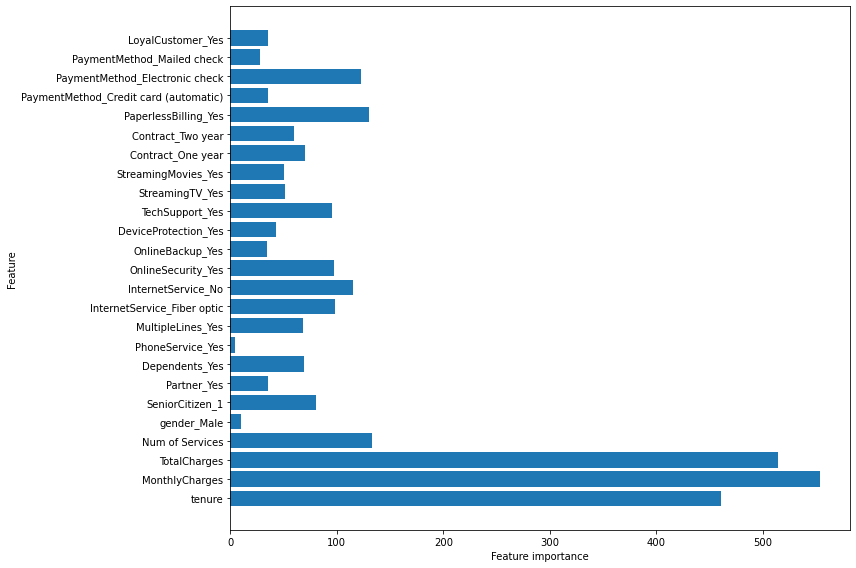

In [119]:
light_best_model = light_grid.best_estimator_

n_features = X_train_scale.shape[1]
plt.figure(figsize=(12,8))
plt.barh(range(n_features), light_best_model.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train_scale.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.tight_layout()

In [120]:
print('Train Performance - LightGBM\n---------------------------------')
light_yhat_train = light_grid.predict(X_train_scale)
light_yhat_proba_train = light_grid.predict_proba(X_train_scale)
light_scores_train= score_pred('LightGBM', 'train', y_train, light_yhat_train, light_yhat_proba_train)

print('Test Performance - LightGBM\n---------------------------------')
light_yhat_test = light_grid.predict(X_test_scale)
light_yhat_proba_test = light_grid.predict_proba(X_test_scale)
light_scores_test = score_pred('LightGBM', 'test', y_test, light_yhat_test, light_yhat_proba_test)

Train Performance - LightGBM
---------------------------------
LightGBM Predictions: ROC AUC 0.87 | Accuracy 0.77 | Precision 0.55 | Recall 0.83 | F1 0.66
Test Performance - LightGBM
---------------------------------
LightGBM Predictions: ROC AUC 0.86 | Accuracy 0.77 | Precision 0.55 | Recall 0.82 | F1 0.66


### Saving models

In [121]:
joblib.dump(lr_grid, 'Models/best_lr_model.pkl')
joblib.dump(rf_grid, 'Models/best_rf_model.pkl')
joblib.dump(xg_grid, 'Models/best_xg_model.pkl')
joblib.dump(light_grid, 'Models/best_light_model.pkl')

clear_output()

### Compare between different models

In [122]:
def plot_ROC_between_models():
    log_fpr, log_tpr, _ = roc_curve(y_test, lr_yhat_proba_test[:, 1])
    rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rf_yhat_proba_test[:, 1])
    xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xg_yhat_proba_test[:, 1])
    light_fpr, light_tpr, _ = roc_curve(y_test, light_yhat_proba_test[:, 1])
    
    ns_proba = [0 for i in range(len(y_test))]
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_proba)
    
    plt.figure(figsize=(12,8))
    
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='NoSkill')
    plt.plot(log_fpr, log_tpr, marker='.', label='LogisticRegression')
    plt.plot(rfc_fpr, rfc_tpr, marker='.', label='RandomRorestClassier')
    plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBClassifier')
    plt.plot(light_fpr, light_tpr, marker='.', label='LightGBM')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    print('LogisticRegression ROC AUC: %.2f' % roc_auc_score(y_test, lr_yhat_proba_test[:, 1]))
    print('RandomForestClassifier ROC AUC: %.2f' % roc_auc_score(y_test, rf_yhat_proba_test[:, 1]))
    print('XGBClassifier ROC AUC: %.2f' % roc_auc_score(y_test, xg_yhat_proba_test[:, 1]))
    print('LightGBM ROC AUC: %.2f' % roc_auc_score(y_test, light_yhat_proba_test[:, 1]))

In [123]:
def plot_PR_between_models():
    log_p, log_r, _ = precision_recall_curve(y_test, lr_yhat_proba_test[:, 1])
    rfc_p, rfc_r, _ = precision_recall_curve(y_test, rf_yhat_proba_test[:, 1])
    xgb_p, xgb_r, _ = precision_recall_curve(y_test, xg_yhat_proba_test[:, 1])
    light_p, light_r, _ = precision_recall_curve(y_test, light_yhat_proba_test[:, 1])
    
    no_skill = len(y_test[y_test == 1]) / len(y_test)
    
    plt.figure(figsize=(12,8))
    
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='NoSkill')
    plt.plot(log_r, log_p, marker='.', label='LogisticRegression')
    plt.plot(rfc_r, rfc_p, marker='.', label='RandomRorestClassier')
    plt.plot(xgb_r, xgb_p, marker='.', label='XGBClassifier')
    plt.plot(light_r, light_p, marker='.', label='LightGBM')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    
    print('LogisticRegression PR AUC: %.2f' % auc(log_r, log_p))
    print('RandomForestClassifier PR AUC: %.2f' % auc(rfc_r, rfc_p))
    print('XGBClassifier PR AUC: %.2f' % auc(xgb_r, xgb_p))
    print('LightGBM PR AUC: %.2f' % auc(light_r, light_p))

#### ROC AUC

LogisticRegression ROC AUC: 0.86
RandomForestClassifier ROC AUC: 0.85
XGBClassifier ROC AUC: 0.86
LightGBM ROC AUC: 0.86


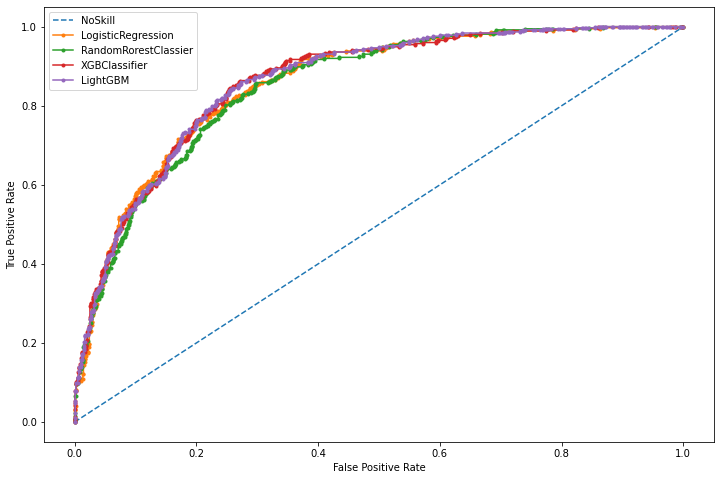

In [124]:
plot_ROC_between_models()

#### PR AUC

LogisticRegression PR AUC: 0.67
RandomForestClassifier PR AUC: 0.66
XGBClassifier PR AUC: 0.68
LightGBM PR AUC: 0.68


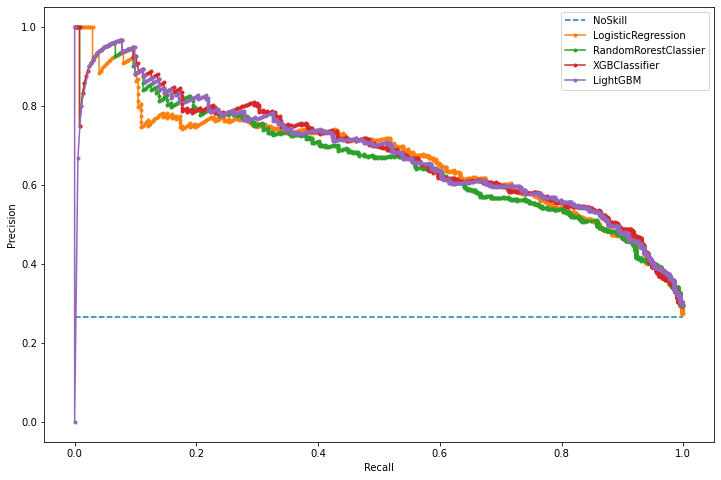

In [125]:
plot_PR_between_models()

#### Model Scores

In [126]:
# lr_grid = joblib.load('Models/best_lr_model.pkl')
# rf_grid = joblib.load('Models/best_rf_model.pkl')
# xg_grid = joblib.load('Models/best_xg_model.pkl')
# light_grid = joblib.load('Models/best_light_model.pkl')

In [127]:
scores_dict = [lr_scores_test, rf_scores_test, xg_scores_test, light_scores_test]

In [128]:
scores_df = pd.DataFrame(scores_dict).sort_values('roc_auc', ascending=False)
scores_df

,model,data,roc_auc,acc,recall,precision,f1
2,XGBClassifier,test,0.861,0.774,0.805,0.551,0.654
3,LightGBM,test,0.861,0.771,0.821,0.546,0.656
0,LogisticRegression,test,0.857,0.755,0.824,0.525,0.641
1,RandomForestClassifer,test,0.851,0.761,0.802,0.533,0.640


In [129]:
scores_df.to_csv('Dataset/Export for Tableau/model_scores.csv', index=False)

##### Sử dụng Tableau để có cái nhìn tốt hơn

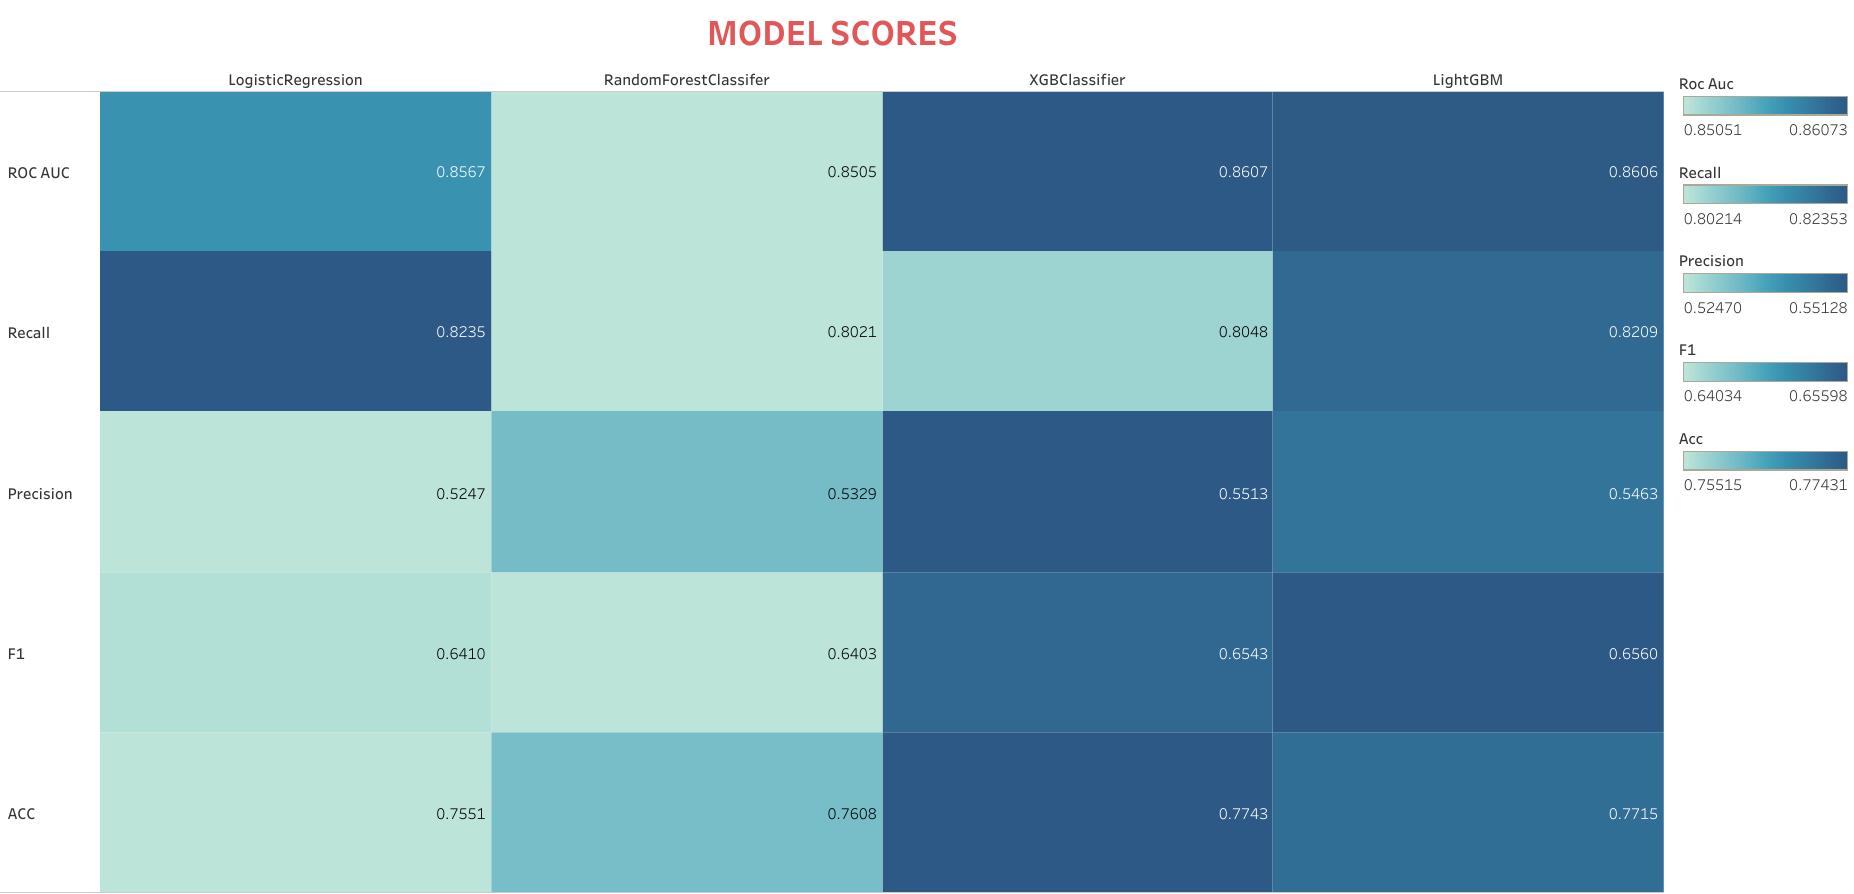

In [4]:
model_scores = Image.open('Images from Tableau/Model Scores.png')
model_scores

#### Feature Importances

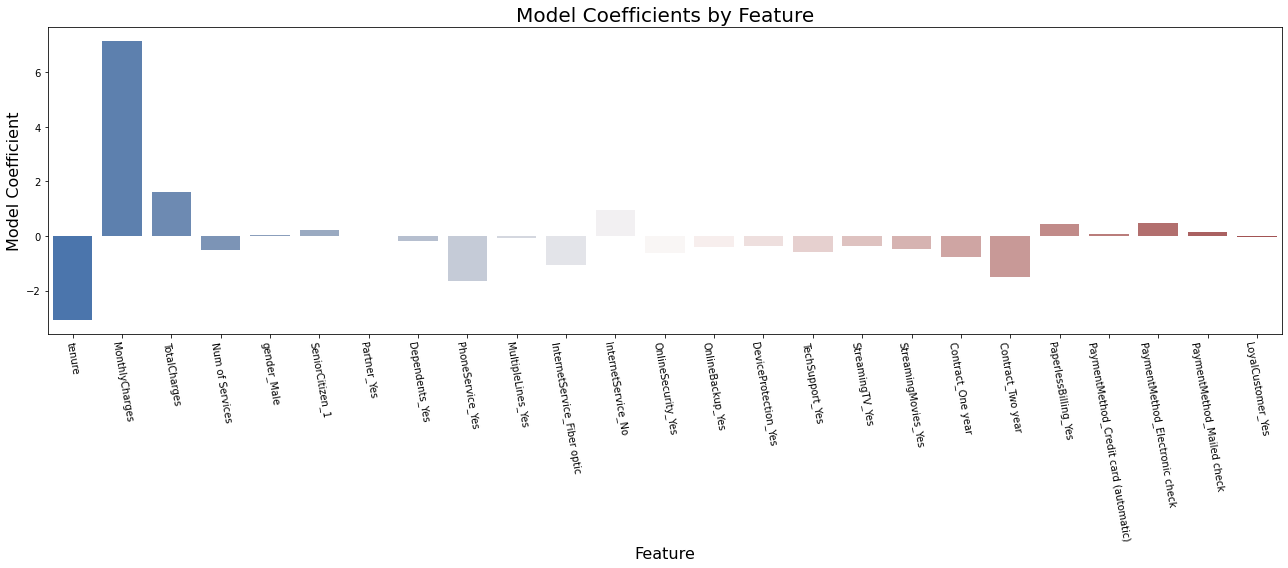

In [131]:
lr_feature_importance = feature_importance(lr_grid.best_estimator_, X_train_scale)['coef'].values

features_dict = {'LogisticRegression': lr_feature_importance,
                 'RandomForestClassifier': rf_grid.best_estimator_.feature_importances_,
                 'XGBClassifier': xg_grid.best_estimator_.feature_importances_,
                 'LightGBM': light_grid.best_estimator_.feature_importances_}

In [132]:
features_df = pd.DataFrame(features_dict, index=X_train_scale.columns.values)
features_df['LogisticRegression'] = np.abs(features_df['LogisticRegression'])
features_df[['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier', 'LightGBM']] = MinMaxScaler().fit_transform(features_df[['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier', 'LightGBM']])

features_df.to_csv('Dataset/Export for Tableau/Model Feature Importances.csv')

##### Sử dụng Tableau để có cái nhìn tốt hơn

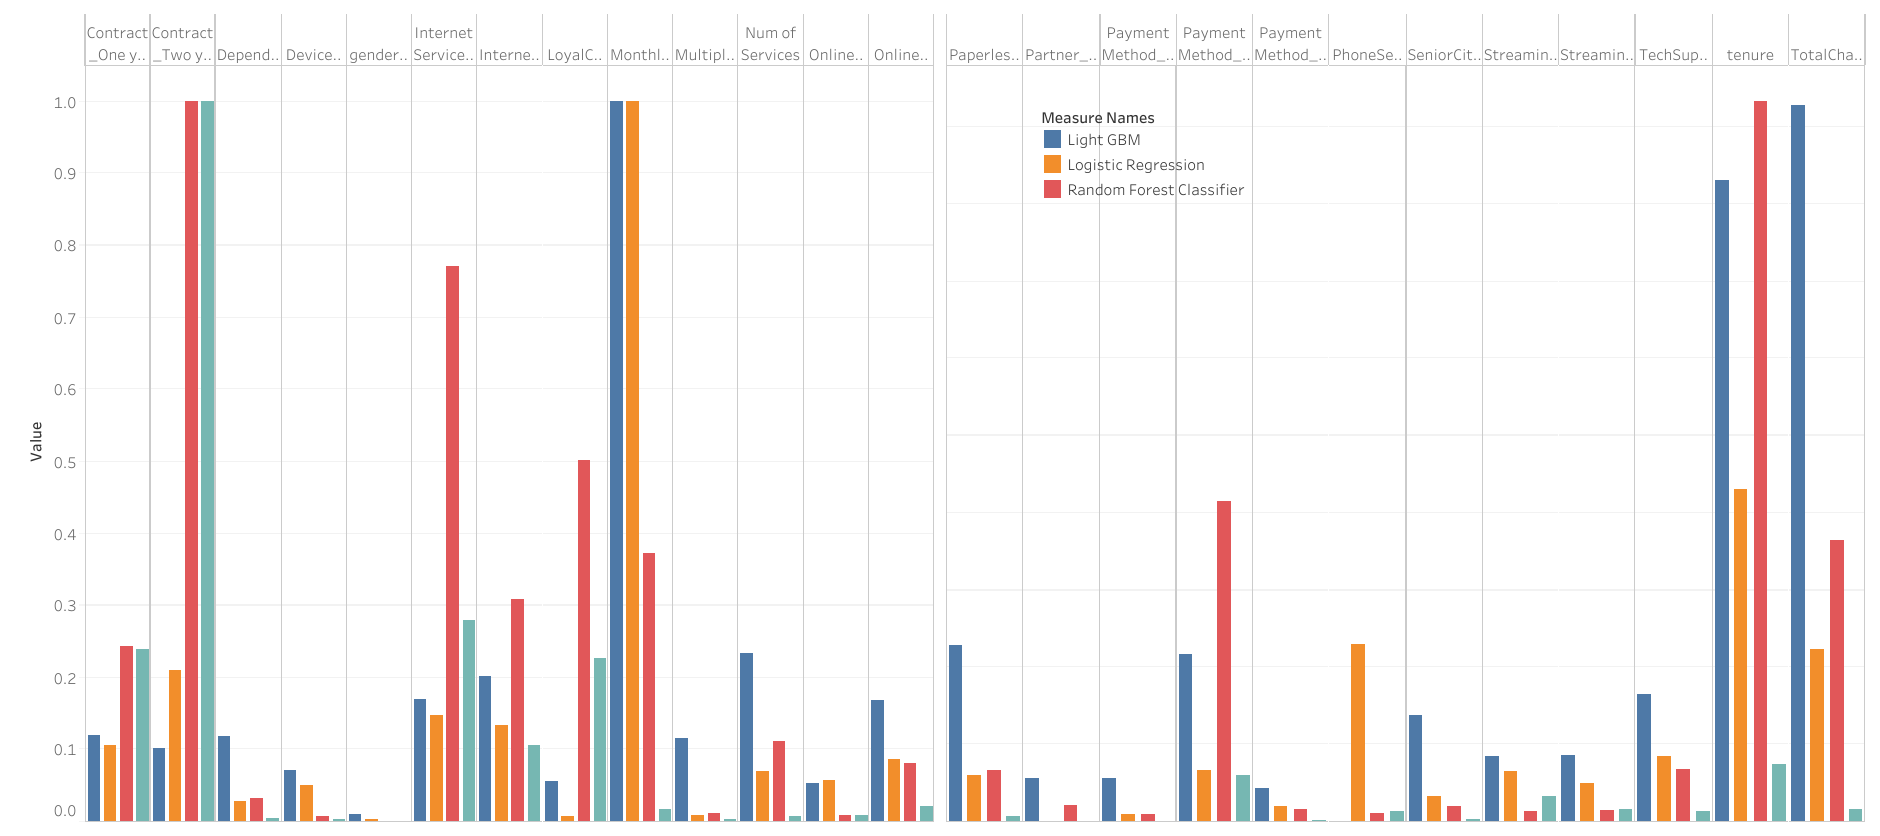

In [5]:
feature_importances = Image.open('Images from Tableau/Feature Importances.png')
feature_importances

# 9. Kết luận

Tập đoàn viễn thông cung cấp dataset với 7043 khách hàng bao gồm về thông tin rằng họ có rời đi vào tháng sau hay không. Sau khi tiến hành phân tích và xử lý dữ liệu, một số mô hình phân loại đã được đưa vào huấn luyện và tối ưu hóa với 80% lượng dữ liệu gốc và sau đó được đem đi dự đoán dựa trên 20% lượng dữ liệu còn lại. Trong số các mô hình được huấn luyện, `LightGBM` đem lại hiệu năng tốt nhất: 

#### 1. Mô hình:
- `LightGBM` được chọn làm mô hình tổng kết cho bài toán 
- Những yếu tố quan trọng mà `LightGBM` bắt được:
    - `MonthlyCharges`: Số tiền mà người dùng đã chi cho tháng này - <b>Mạnh</b>
    - `TotalCharges`: Số tiền mà người dùng đã chi cho công ty - <b>Mạnh</b>
    - `tenure`: Tổng số tháng người dùng đăng kí - <b>Mạnh</b>
    - `NumOfService`: Tổng số dịch vụ đăng kí không bắt buộc - <b>Trung bình</b>
    - `PaperlessBilling`: Dịch vụ lựa chọn dành cho người dùng đăng kí - <b>Trung bình</b>
    - `PaymentMethod`: Dịch vụ lựa chọn dành cho người dùng đăng kí - <b>Yếu</b>
    - `InternetService`: Dịch vụ lựa chọn dành cho người dùng đăng kí - <b>Yếu</b>
- Hiệu năng mô hình:
    - `86.1%` ROC AUC: Mô hình dự đoán gần đúng với 7 trên 8 trường hợp người dùng
    - `82.1%` Recall: Mô hình dự đoán được `82.1%` trường hợp người dùng có rời đi vào tháng sau hay không
    - `54.6%` Precision: Mô hình dự đoán gần `50%` trường hợp người dùng rời đi là sai 

#### 2. Kết luận chung
- Mô hình:
    - Với `86.1%` ROC AUC cho dữ liệu chưa từng thấy, mô hình của chúng ta hoạt động khá tốt và có thể áp dụng bài toán vào thực tế
    - Với tỉ lệ `Recall` cao hơn `Precision`, mô hình sẽ phù hợp với những công ty có thể cung cấp lượng ngân sách lớn cho chiến dịch giữ chân khách hàng
- Giải pháp:
    - Về phân khúc tuổi, có thể thấy được những `SeniorCitizen` cung cấp doanh thu cho công ty tốt hơn nhưng tỉ lệ rời đi của họ lại khá cao. Có thể vì họ là những người lớn tuổi nên họ sẽ không ngần ngại trong việc chi tiền cho những dịch vụ của công ty. Nhưng có thể họ có xu hướng dành thời gian cho con cháu hay những hoạt động ngoài trời, nên sau khi đã trải nghiệm hầu hết những dịch vụ đã đăng kí, họ sẽ không còn cảm thấy muốn tiếp tục nữa. Vì vậy, công ty nên có những chính sách giữ chân hợp lý đối với nhóm khách hàng này.
    - Những người có `Partner` và `Dependents` sẽ là miếng mồi béo bở cho công ty. Chúng ta nên tăng sự cường tiếp cận và quảng bá dịch vụ đến nhóm khách hàng này vì họ cung cấp rất nhiều doanh thu cho công ty cũng như thời gian ở lại của họ lâu hơn.
    - Đối với `tenure`, có thể thấy được những người dùng đăng kí trên 2 năm sẽ đi vào ổn định và họ sẽ có khá ít khả năng rời đi. Ngược lại, nhóm khách hàng có `tenure` dưới 2 năm có tỉ lệ rời đi khá cao với `tenure` càng thấp thì tỉ lệ rời đi sẽ cao hơn. Vì vậy, chúng ta nên tập trung vào nhóm khách hàng có `tenure` dưới 2 năm, một khi thành công và `tenure` của họ vượt quá 2 năm có nghĩa là chúng ta đã giữ chân khách hàng thành công.
    - Đối với `InternetService`, chúng ta nên dành sự quan tâm cho gói <b>Fiber optic</b> vì đây sẽ là gói cung cấp doanh thu chính cho công ty và gói này đang thật sự rất tệ. Mặc dù nó đã được quảng bá rất tốt với tỉ lệ đăng kí cao ngất ngưởng, những thật sự thì người dùng đăng kí gói này có tỉ lệ rời đi vào tháng sau lên tới <b>41.89%</b>. Vì doanh thu mà gói này đem lại rất cao, kể cả những người dùng lâu năm (`tenure` > 2 năm) cũng đăng kí gói này rất nhiều nên chúng ta phải dành sự quan tâm đặc biệt để có cải thiệt chất lượng cho gói dịch vụ này. Giải pháp là chúng ta có thể gửi email những câu hỏi để tìm hiểu lý do vì sao họ lại rời đi/hủy dịch vụ. Từ đó có thể thấy được phần nào đó vấn đề của gói `Fiber optic` này.
    - Đối với `OnlineSecurity`, `OnlineBackup`, `DeviceProtection` và `TechSupport`, tỉ lệ người dùng rời đi sau khi đăng kí những gói dịch vụ này là khá ít là rất tốt, trái ngược với tỉ lệ rời đi rất cao của những người không đăng kí cho thấy giá trị mà những gói dịch vụ này mang lại là rất cao. Nhưng tỉ lệ đăng kí của người dùng đối với những gói dịch vụ này là còn khá ít. Vì vậy, chúng ta cần có chiến dịch đẩy mạnh quảng bá những gói dịch vụ này đến với tất cả người dùng.
    - Đối với `StreamingTV` và `StreamingMovies`, người dùng đăng kí những gói dịch vụ này có xu hướng ở lại với công ty lâu hơn những người không đăng kí. Tỉ lệ đăng kí gói cũng khá cao nhưng tỉ lệ rời đi vào tháng sau cũng rất cao cho thấy chúng ta cần cải thiện và nâng cấp chất lượng của nhóm dịch vụ này. Có thể cập nhật thêm những bộ phim/kênh mới, phù hợp với thị hiếu của phần lớn khách hàng.
    - Đối với `Contract`, chất lượng của gói `Contract` thời lượng <b>2 năm</b> là thật sự ấn tượng với tỉ lệ đăng kí cao cũng như tỉ lệ rời đi cực thấp. Vì thế chúng ta nên tăng cường quảng bá chất lượng của gói `Contract` này tới với người dùng. Cùng với đó, chúng ta cũng nên nâng cấp/cải thiện chất lượng của gói `Contract` thời lượng <b>theo tháng</b> vì tỉ lệ rời đi của người dùng gói này đang rất cao và số lượng người dùng đăng kí gói này cũng đang khá nhiều. Chúng ta có thể gửi email câu hỏi và tìm hiểu feedback từ những khách hàng này, từ đó nhận ra được những thứ còn thiếu của gói `Contract` đấy.
    - Gói `PaperlessBilling` đang không thực sự phát huy được tác dụng của nó khi tỉ lệ rời đi của người đăng kí là khá cao. Vì thế chúng ta nên có những giải pháp hiệu quả để cải thiện chất lượng của gói đăng kí này.
    - Đối với `PaymentMethod`, gói mang lại doanh thu chính cho công ty là `Electronic check` đang thật sự không chất lượng vì tỉ lệ rời đi của người đăng kí là rất cao với gần `50%`. Trái lại, chất lượng mà 2 gói <b>automatic</b> là `Bank transfer` và `Credit card` mang lại là rất tốt vì người dùng đăng kí có xu hướng ở lại với công ty lâu hơn rất nhiều. Vì vậy, chúng ta nên tập trung nâng cấp/cải thiện chất lượng của góp `Electronic check` để giữ chân người dùng cũng nhưng tăng cường quảng bá 2 gói <b>automatic</b> đến với người dùng. Giải pháp vẫn có thể là gửi email thu thập ý kiến của người dùng.
    - Đối với `MonthlyCharges`, điều đáng chú ý là những người có xu hướng chi tiêu mạnh trong tháng lại có khả năng rời đi cao hơn, còn những người dùng đăng ký lâu năm có xu hướng ổn định chi tiêu của họ. Vì vậy, chúng ta nên chú ý vào nhóm người dùng cung cấp cao doanh thu cho công ty trong tháng và chắc chắn rằng họ có rời đi vào tháng sau hay không, từ đó đưa ra giải pháp kịp thời để giữ chân người dùng.
    - Những yếu tố/dịch vụ còn lại có thể không ảnh hưởng mạnh đến việc người dùng có rời đi vào tháng sau hay không hoặc chúng ta sẽ cần thêm thời gian để khám phá thêm.